# Figures notebook for Fission Fragment 2

In [1]:
from cheftgp.eft import *
from cheftgp.gaussianprocess import *
from cheftgp.graphs import *
from cheftgp.scattering import *
from cheftgp.utils import *
from cheftgp.potentials import *
from scripts.generator_fns import *

import scipy
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit
from scipy.interpolate import interpn

%matplotlib inline

In [2]:
mpl.rc(
        "savefig",
        transparent=False,
        bbox="tight",
        pad_inches=0.05,
        dpi=300,
        format="png",
    )

## Plots values of $\Lambda_{b}$ and $m_{\rm eff}$ for potentials under test

In [3]:
import pandas as pd

# creates a Pandas DataFrame object of information about Lambda_b and m_eff for different 
# observables and all possible scheme/scale combinations, and outputs as a table
lambdab_meff_data = [
["SMS" , "550MeV" , "N4LO+" , "ALL2DOBS" , 560 , 10 , 127 , 2 ,], 
["SMS" , "550MeV" , "N4LO" , "ALL2DOBS" , 450 , 10 , 110 , 3 ,], 
["SMS" , "550MeV" , "N3LO" , "ALL2DOBS" , 380 , 10 , 41 , 2 ,], 
["SMS" , "550MeV" , "N2LO" , "ALL2DOBS" , 370 , 20 , 38 , 2 ,], 
["SMS" , "500MeV" , "N4LO+" , "ALL2DOBS" , 570 , 10 , 138 , 3 ,], 
["SMS" , "500MeV" , "N4LO" , "ALL2DOBS" , 530 , 10 , 120 , 3 ,], 
["SMS" , "500MeV" , "N3LO" , "ALL2DOBS" , 450 , 10 , 63 , 2 ,], 
["SMS" , "500MeV" , "N2LO" , "ALL2DOBS" , 420 , 20 , 35 , 2 ,], 
["SMS" , "450MeV" , "N4LO+" , "ALL2DOBS" , 580 , 10 , 154 , 3 ,], 
["SMS" , "450MeV" , "N4LO" , "ALL2DOBS" , 570 , 20 , 130 , 3 ,], 
["SMS" , "450MeV" , "N3LO" , "ALL2DOBS" , 460 , 20 , 95 , 4 ,], 
["SMS" , "450MeV" , "N2LO" , "ALL2DOBS" , 510 , 30 , 32 , 2 ,], 
["SMS" , "400MeV" , "N4LO+" , "ALL2DOBS" , 610 , 10 , 163 , 3 ,], 
["SMS" , "400MeV" , "N4LO" , "ALL2DOBS" , 540 , 20 , 123 , 4 ,], 
["SMS" , "400MeV" , "N3LO" , "ALL2DOBS" , 400 , 10 , 104 , 4 ,], 
["SMS" , "400MeV" , "N2LO" , "ALL2DOBS" , 630 , 30 , 35 , 3 ,], 
["SCS" , "0.8fm" , "N4LO" , "ALL2DOBS" , 590 , 20 , 105 , 3 ,], 
["SCS" , "0.8fm" , "N3LO" , "ALL2DOBS" , 440 , 10 , 48 , 2 ,], 
["SCS" , "0.8fm" , "N2LO" , "ALL2DOBS" , 400 , 20 , 36 , 2 ,], 
["SCS" , "0.9fm" , "N4LO" , "ALL2DOBS" , 720 , 20 , 120. , 3 ,], 
["SCS" , "0.9fm" , "N3LO" , "ALL2DOBS" , 610 , 20 , 69 , 3 ,], 
["SCS" , "0.9fm" , "N2LO" , "ALL2DOBS" , 490 , 30 , 40 , 3 ,], 
["SCS" , "1.0fm" , "N4LO" , "ALL2DOBS" , 680 , 20 , 122 , 3 ,], 
["SCS" , "1.0fm" , "N3LO" , "ALL2DOBS" , 520 , 20 , 80 , 3 ,], 
["SCS" , "1.0fm" , "N2LO" , "ALL2DOBS" , 640 , 40 , 47 , 3 ,], 
["SCS" , "1.1fm" , "N4LO" , "ALL2DOBS" , 620 , 20 , 117 , 3 ,], 
["SCS" , "1.1fm" , "N3LO" , "ALL2DOBS" , 460 , 10 , 81 , 3 ,], 
["SCS" , "1.1fm" , "N2LO" , "ALL2DOBS" , 790 , 50 , 53 , 3 ,], 
["SCS" , "1.2fm" , "N4LO" , "ALL2DOBS" , 570 , 20 , 112 , 3 ,], 
["SCS" , "1.2fm" , "N3LO" , "ALL2DOBS" , 400 , 10 , 75 , 3 ,], 
["SCS" , "1.2fm" , "N2LO" , "ALL2DOBS" , 850 , 50 , 54 , 3 ,], 
["EMN" , "550MeV" , "N4LO" , "ALL2DOBS" , 530 , 20 , 75 , 2 ,], 
["EMN" , "550MeV" , "N3LO" , "ALL2DOBS" , 380 , 10 , 41 , 2 ,], 
["EMN" , "550MeV" , "N2LO" , "ALL2DOBS" , 420 , 20 , 5 , 1 ,], 
["EMN" , "500MeV" , "N4LO" , "ALL2DOBS" , 510 , 10 , 63 , 2 ,], 
["EMN" , "500MeV" , "N3LO" , "ALL2DOBS" , 380 , 10 , 30 , 2 ,], 
["EMN" , "500MeV" , "N2LO" , "ALL2DOBS" , 420 , 20 , 18 , 2 ,], 
["EMN" , "450MeV" , "N4LO" , "ALL2DOBS" , 480 , 10 , 62 , 2 ,], 
["EMN" , "450MeV" , "N3LO" , "ALL2DOBS" , 400 , 10 , 36 , 2 ,], 
["EMN" , "450MeV" , "N2LO" , "ALL2DOBS" , 410 , 20 , 15 , 2 ,], 
["GT+" , "0.9fm" , "N2LO" , "ALL2DOBS" , 560 , 30 , 21 , 2 ,], 
["GT+" , "1.0fm" , "N2LO" , "ALL2DOBS" , 720 , 40 , 22 , 1 ,], 
["GT+" , "1.1fm" , "N2LO" , "ALL2DOBS" , 890 , 50 , 24 , 2 ,], 
["GT+" , "1.2fm" , "N2LO" , "ALL2DOBS" , 1010 , 60 , 24 , 1 ,], 
# ["Norfolk" , "(0.8,0.6)fm" , "N2LO" , , , , ,], 
# ["Norfolk" , "(1.0,0.7)fm" , "N2LO" , , , , ,], 
# ["Norfolk" , "(1.2,0.8)fm" , "N2LO" , , , , ,], 
# ["GO" , "500MeV" , "N2LO" , , , , ,], 
# ["GO" , "450MeV" , "N2LO" , , , , ,], 
    
["SMS" , "550MeV" , "N4LO+" , "SGT" , 900 , 100 , 320 , 50 ,], 
["SMS" , "550MeV" , "N4LO" , "SGT" , 700 , 100 , 340 , 80 ,], 
["SMS" , "550MeV" , "N3LO" , "SGT" , 700 , 100 , 300 , 100 ,], 
["SMS" , "550MeV" , "N2LO" , "SGT" , 1300 , 500 , 500 , 100 ,], 
["SMS" , "500MeV" , "N4LO+" , "SGT" , 1100 , 100 , 370 , 60 ,], 
["SMS" , "500MeV" , "N4LO" , "SGT" , 1000 , 200 , 390 , 90 ,], 
["SMS" , "500MeV" , "N3LO" , "SGT" , 1100 , 300 , 400 , 200 ,], 
["SMS" , "500MeV" , "N2LO" , "SGT" , 1700 , 500 , 500 , 100 ,], 
["SMS" , "450MeV" , "N4LO+" , "SGT" , 1100 , 200 , 440 , 70 ,], 
["SMS" , "450MeV" , "N4LO" , "SGT" , 1000 , 200 , 460 , 90 ,], 
["SMS" , "450MeV" , "N3LO" , "SGT" , 900 , 200 , 480 , 90 ,], 
["SMS" , "450MeV" , "N2LO" , "SGT" , 1900 , 500 , 400 , 100 ,], 
["SMS" , "400MeV" , "N4LO+" , "SGT" , 1000 , 200 , 430 , 60 ,], 
["SMS" , "400MeV" , "N4LO" , "SGT" , 800 , 200 , 400 , 70 ,], 
["SMS" , "400MeV" , "N3LO" , "SGT" , 700 , 100 , 400 , 90 ,], 
["SMS" , "400MeV" , "N2LO" , "SGT" , 1900 , 400 , 200 , 200 ,], 
["SCS" , "0.8fm" , "N4LO" , "SGT" , 700 , 100 , 250 , 60 ,], 
["SCS" , "0.8fm" , "N3LO" , "SGT" , 700 , 200 , 200 , 100 ,], 
["SCS" , "0.8fm" , "N2LO" , "SGT" , 1100 , 500 , 400 , 100 ,], 
["SCS" , "0.9fm" , "N4LO" , "SGT" , 900 , 100 , 300 , 60 ,], 
["SCS" , "0.9fm" , "N3LO" , "SGT" , 900 , 200 , 350 , 90 ,], 
["SCS" , "0.9fm" , "N2LO" , "SGT" , 1400 , 500 , 500 , 100 ,], 
["SCS" , "1.0fm" , "N4LO" , "SGT" , 700 , 100 , 290 , 80 ,], 
["SCS" , "1.0fm" , "N3LO" , "SGT" , 700 , 100 , 300 , 100 ,], 
["SCS" , "1.0fm" , "N2LO" , "SGT" , 1600 , 500 , 500 , 100 ,], 
["SCS" , "1.1fm" , "N4LO" , "SGT" , 600 , 100 , 240 , 60 ,], 
["SCS" , "1.1fm" , "N3LO" , "SGT" , 600 , 100 , 300 , 100 ,], 
["SCS" , "1.1fm" , "N2LO" , "SGT" , 1700 , 400 , 500 , 100 ,], 
["SCS" , "1.2fm" , "N4LO" , "SGT" , 570 , 90 , 200 , 40 ,], 
["SCS" , "1.2fm" , "N3LO" , "SGT" , 500 , 80 , 210 , 90 ,], 
["SCS" , "1.2fm" , "N2LO" , "SGT" , 1900 , 400 , 500 , 100 ,], 
["EMN" , "550MeV" , "N4LO" , "SGT" , 1000 , 200 , 160 , 40 ,], 
["EMN" , "550MeV" , "N3LO" , "SGT" , 800 , 200 , 130 , 50 ,], 
["EMN" , "550MeV" , "N2LO" , "SGT" , 900 , 400 , 150 , 90 ,], 
["EMN" , "500MeV" , "N4LO" , "SGT" , 1300 , 300 , 210 , 50 ,], 
["EMN" , "500MeV" , "N3LO" , "SGT" , 800 , 200 , 120 , 40 ,], 
["EMN" , "500MeV" , "N2LO" , "SGT" , 800 , 300 , 140 , 70 ,], 
["EMN" , "450MeV" , "N4LO" , "SGT" , 900 , 200 , 150 , 30 ,], 
["EMN" , "450MeV" , "N3LO" , "SGT" , 700 , 200 , 120 , 30 ,], 
["EMN" , "450MeV" , "N2LO" , "SGT" , 700 , 300 , 140 , 70 ,], 
["GT+" , "0.9fm" , "N2LO" , "SGT" , 1500 , 500 , 400 , 100 ,], 
["GT+" , "1.0fm" , "N2LO" , "SGT" , 1700 , 500 , 400 , 100 ,], 
["GT+" , "1.1fm" , "N2LO" , "SGT" , 1800, 400 , 400, 100 ,], 
["GT+" , "1.2fm" , "N2LO" , "SGT" , 1900, 500 , 400 , 100 ,], 
# ["Norfolk" , "(0.8,0.6)fm" , "N2LO" , , , , ,], 
# ["Norfolk" , "(1.0,0.7)fm" , "N2LO" , , , , ,], 
# ["Norfolk" , "(1.2,0.8)fm" , "N2LO" , , , , ,], 
# ["GO" , "500MeV" , "N2LO" , , , , ,], 
# ["GO" , "450MeV" , "N2LO" , , , , ,], 
]

lambda_meff_df = pd.DataFrame(lambdab_meff_data, 
        columns = ["Potential", "Cutoff", "Max. order", "Observable(s)", 
                   "Lambdab_mean", "Lambdab_stddev", "meff_mean", "meff_stddev"])

pd.set_option('display.max_rows', len(lambda_meff_df))
display(lambda_meff_df)
pd.reset_option('display.max_rows')


,Potential,Cutoff,Max. order,Observable(s),Lambdab_mean,Lambdab_stddev,meff_mean,meff_stddev
0,SMS,550MeV,N4LO+,ALL2DOBS,560,10,127.0,2
1,SMS,550MeV,N4LO,ALL2DOBS,450,10,110.0,3
2,SMS,550MeV,N3LO,ALL2DOBS,380,10,41.0,2
3,SMS,550MeV,N2LO,ALL2DOBS,370,20,38.0,2
4,SMS,500MeV,N4LO+,ALL2DOBS,570,10,138.0,3
5,SMS,500MeV,N4LO,ALL2DOBS,530,10,120.0,3
6,SMS,500MeV,N3LO,ALL2DOBS,450,10,63.0,2
7,SMS,500MeV,N2LO,ALL2DOBS,420,20,35.0,2
8,SMS,450MeV,N4LO+,ALL2DOBS,580,10,154.0,3
9,SMS,450MeV,N4LO,ALL2DOBS,570,20,130.0,3


In [4]:
# dicts for plotting
potential_color_dict = {"SMS" : "dodgerblue", "SCS" : "deeppink", 
                       "GT+" : "darkorange", "EMN" : "forestgreen"}
order_marker_dict = {"N4LO+" : "d", "N4LO" : "s", "N3LO" : "^", "N2LO" : "o"}
order_name_order_label_dict = {"N4LO+" : "N$^{4}$LO+", "N4LO" : "N$^{4}$LO", 
                        "N3LO" : "N$^{3}$LO", "N2LO" : "N$^{2}$LO"}
order_name_coeff_name_dict = {"N4LO+" : "c6", "N4LO" : "c5", "N3LO" : "c4", "N2LO" : "c3"}
order_name_coeff_label_dict = {"N4LO+" : "$c_{6}$", "N4LO" : "$c_{5}$", 
                               "N3LO" : "$c_{4}$", "N2LO" : "$c_{3}$"}

In [5]:
# generic linear fit function, with Lambda_b = a * m_eff + b
def Lambdab_meff_linear(x, a, b):
    return a * x + b

In [6]:
# useful little function for eliminating duplicate labels in the legend
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

#### Plots $\Lambda_{b}$ vs. $m_{\rm eff}$ (as generated by combining all two-dimensional observables) at all orders for all potentials, with lines of best fit

EMN (N2LO): Lambda_b = (-0.3 +/- 0.8) m_eff + (420 +/-  11) MeV
EMN (N3LO): Lambda_b = (0.1 +/- 2.1) m_eff + (383 +/-  75) MeV
EMN (N4LO): Lambda_b = (2.9 +/- 1.9) m_eff + (311 +/- 126) MeV
GT+ (N2LO): Lambda_b = (126.7 +/- 24.0) m_eff + (-2087 +/- 548) MeV
SCS (N2LO): Lambda_b = (24.1 +/- 1.2) m_eff + (-476 +/-  56) MeV
SCS (N3LO): Lambda_b = (0.7 +/- 3.5) m_eff + (436 +/- 249) MeV
SCS (N4LO): Lambda_b = (7.2 +/- 3.2) m_eff + (-199 +/- 374) MeV
SMS (N2LO): Lambda_b = (-23.3 +/- 28.5) m_eff + (1299 +/- 1000) MeV
SMS (N3LO): Lambda_b = (0.5 +/- 0.9) m_eff + (386 +/-  70) MeV
SMS (N4LO): Lambda_b = (6.1 +/- 0.8) m_eff + (-209 +/- 101) MeV
SMS (N4LO+): Lambda_b = (1.2 +/- 0.3) m_eff + (398 +/-  51) MeV


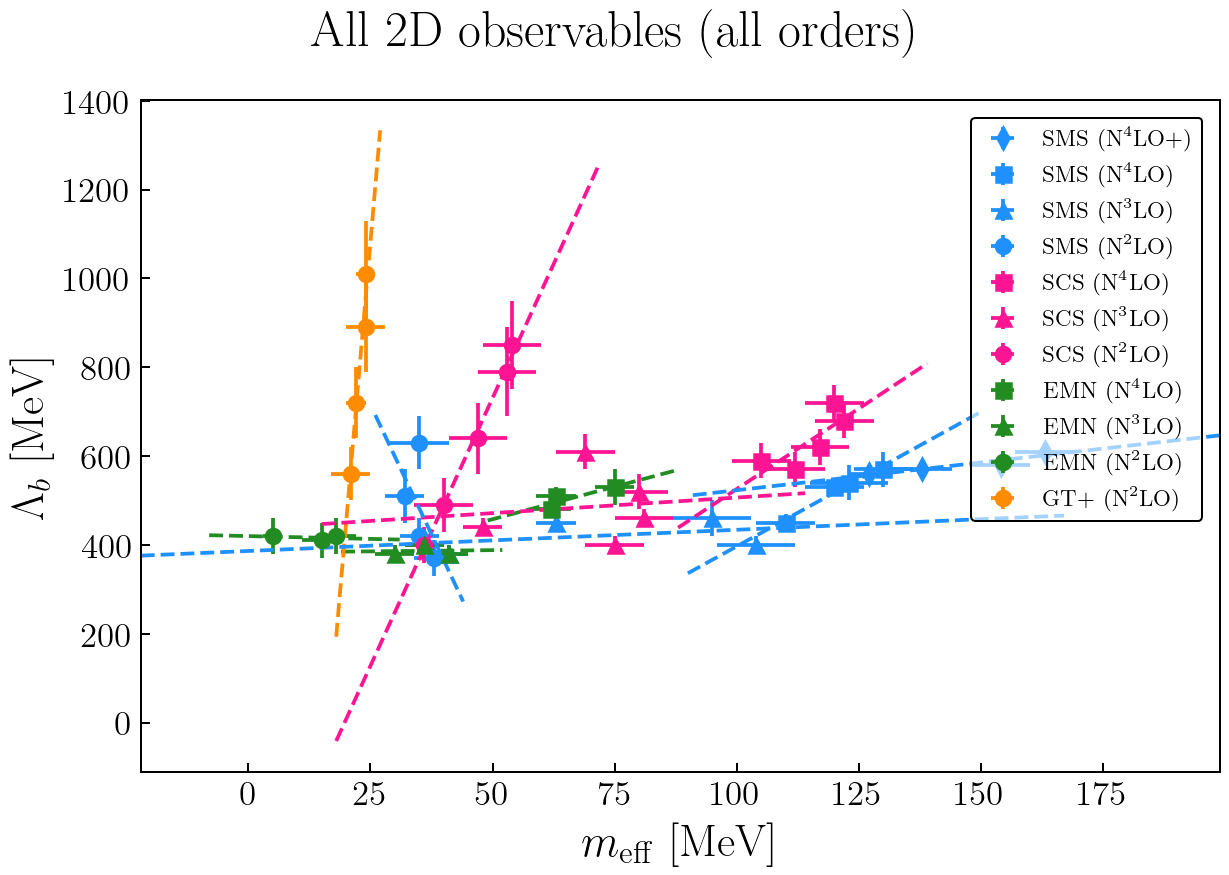

In [7]:
fig_fit_all2dobs_allo, ax_fit_all2dobs_allo = plt.subplots(figsize=(7,5))

for index, row in lambda_meff_df[lambda_meff_df["Observable(s)"] == "ALL2DOBS"].iterrows():
    # scatter-plots the means and 95% (2 sigma) confidence intervals for the scale values
    ax_fit_all2dobs_allo.errorbar(row["meff_mean"], row["Lambdab_mean"], 
                    xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
                    color = potential_color_dict[row["Potential"]], 
                    label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
                    fmt = order_marker_dict[row["Max. order"]])

# selects only the 2D observables' data
pot_order_combo = lambda_meff_df[lambda_meff_df["Observable(s)"] == "ALL2DOBS"].groupby(['Potential', 'Max. order'])

for (pot, order), row in pot_order_combo:
    # fits the points to a line
    popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
                        row["meff_mean"], row["Lambdab_mean"])
    # plots the line of best fit
    ax_fit_all2dobs_allo.plot(
        np.linspace(2 * np.min(row["meff_mean"]) - np.max(row["meff_mean"]), 
                    2 * np.max(row["meff_mean"]) - np.min(row["meff_mean"]), 
                    100), 
                Lambdab_meff_linear(
                    np.linspace(2 * np.min(row["meff_mean"]) - np.max(row["meff_mean"]), 
                                2 * np.max(row["meff_mean"]) - np.min(row["meff_mean"]), 
                                100), 
                    popt[0], popt[1]), 
                color = potential_color_dict[pot], 
               linestyle = "--", 
               )
    # prints the best fit values
    print(pot + " (" + order + f"): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
         f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

fig_fit_all2dobs_allo.suptitle("All 2D observables (all orders)", fontsize = 20)
ax_fit_all2dobs_allo.set_xlabel("$m_{\mathrm{eff}}$ [MeV]", fontsize = 18)
ax_fit_all2dobs_allo.set_ylabel(r"$\Lambda_{b}$ [MeV]", fontsize = 18)
ax_fit_all2dobs_allo.legend(
            fontsize = 10,
          loc='center left',
          bbox_to_anchor=(1, 0.5),
          handletextpad=0.02,
          borderpad=0.2)

legend_without_duplicate_labels(ax_fit_all2dobs_allo)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig_fit_all2dobs_allo.tight_layout()
plt.show()
fig_fit_all2dobs_allo.savefig('figures2/' + 'Lambdab_vs_meff_all2dobs_allo')

In [8]:
# fig_fit_sgt_allo, ax_fit_sgt_allo = plt.subplots(figsize=(7,5))

# # for index, row in lambda_meff_df.iterrows():
# #     # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
# #     ax_fit_all2dobs_allo.errorbar(row["meff_mean"], row["Lambdab_mean"], 
# #                     xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
# #                     color = potential_color_dict[row["Potential"]], 
# #                     label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
# #                     fmt = order_marker_dict[row["Max. order"]])
    
# for index, row in lambda_meff_df[lambda_meff_df["Observable(s)"] == "ALL2DOBS"].iterrows():
#     # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
#     ax_fit_all2dobs_allo.errorbar(row["meff_mean"], row["Lambdab_mean"], 
#                     xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
#                     color = potential_color_dict[row["Potential"]], 
#                     label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
#                     fmt = order_marker_dict[row["Max. order"]])

# pot_order_combo = lambda_meff_df[lambda_meff_df["Observable(s)"] == "ALL2DOBS"].groupby(['Potential', 'Max. order'])

# for (pot, order), row in pot_order_combo:
# #     print(pot)
# #     print(order)
# #     print(row)
#     # fits the points to a line
#     popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
#                         row["meff_mean"], row["Lambdab_mean"])
#     # plots the line of best fit
#     ax_fit_all2dobs_allo.plot(
#         np.linspace(2 * np.min(row["meff_mean"]) - np.max(row["meff_mean"]), 
#                     2 * np.max(row["meff_mean"]) - np.min(row["meff_mean"]), 
#                     100), 
#                 Lambdab_meff_linear(
#                     np.linspace(2 * np.min(row["meff_mean"]) - np.max(row["meff_mean"]), 
#                                 2 * np.max(row["meff_mean"]) - np.min(row["meff_mean"]), 
#                                 100), 
#                     popt[0], popt[1]), 
#                 color = potential_color_dict[pot], 
#                linestyle = "--", 
# #                label = rf"${popt[0]:.1f} m_{{\mathrm{{eff}}}} + {popt[1]:3.0f}\,\mathrm{{MeV}}$"
#                )
#     # prints the best fit values
#     print(pot + " (" + order + f"): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
#          f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

# fig_fit_all2dobs_allo.suptitle("All 2D observables (all orders)", fontsize = 20)
# ax_fit_all2dobs_allo.set_xlabel("$m_{\mathrm{eff}}$ [MeV]", fontsize = 18)
# ax_fit_all2dobs_allo.set_ylabel(r"$\Lambda_{b}$ [MeV]", fontsize = 18)
# # ax_fit.legend(fontsize = 10, 
# #               loc = 'upper right', 
# #               ncols = 2)
# ax_fit_all2dobs_allo.legend(
#             fontsize = 10,
#           loc='center left',
#           bbox_to_anchor=(1, 0.5),
#           handletextpad=0.02,
#           borderpad=0.2)

# legend_without_duplicate_labels(ax_fit_all2dobs_allo)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# fig_fit_all2dobs_allo.tight_layout()
# plt.show()
# fig_fit_all2dobs_allo.savefig('figures2/' + 'Lambdab_vs_meff_sgt_allo')

#### Plots $\Lambda_{b}$ vs. $m_{\rm eff}$ (as generated by combining all two-dimensional observables) at highest order for all potentials

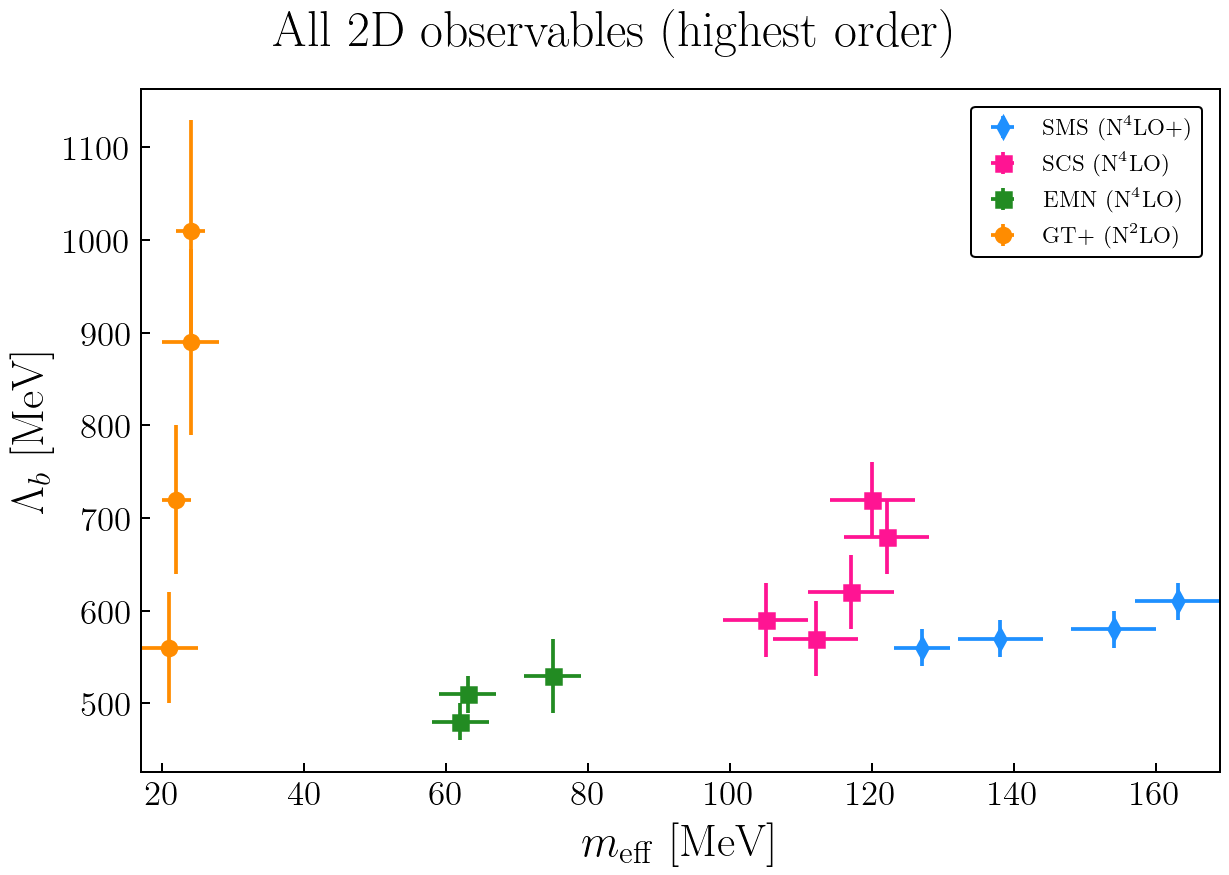

In [9]:
fig_fit_all2dobs_ho, ax_fit_all2dobs_ho = plt.subplots(figsize=(7,5))

# groups information by potential, cutoff, and observable
pot_cutoff_combo = lambda_meff_df[lambda_meff_df["Observable(s)"] == "ALL2DOBS"].groupby(['Potential', 'Cutoff']).head(1)
for index, row in pot_cutoff_combo.iterrows():
    # scatter-plots the means and 95% (2 sigma) confidence intervals for the scale values
    ax_fit_all2dobs_ho.errorbar(row["meff_mean"], row["Lambdab_mean"], 
                    xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
                    color = potential_color_dict[row["Potential"]], 
                    label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
                    fmt = order_marker_dict[row["Max. order"]])

fig_fit_all2dobs_ho.suptitle("All 2D observables (highest order)", fontsize = 20)
ax_fit_all2dobs_ho.set_xlabel("$m_{\mathrm{eff}}$ [MeV]", fontsize = 18)
ax_fit_all2dobs_ho.set_ylabel(r"$\Lambda_{b}$ [MeV]", fontsize = 18)
ax_fit_all2dobs_ho.legend(
            fontsize = 10,
          loc='center left',
          bbox_to_anchor=(1, 0.5),
          handletextpad=0.02,
          borderpad=0.2)

legend_without_duplicate_labels(ax_fit_all2dobs_ho)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig_fit_all2dobs_ho.tight_layout()
plt.show()
fig_fit_all2dobs_ho.savefig('figures2/' + 'Lambdab_vs_meff_all2dobs_ho')

#### Plots $\Lambda_{b}$ vs. $m_{\rm eff}$ (as generated from the total cross section data alone) at highest order for all potentials

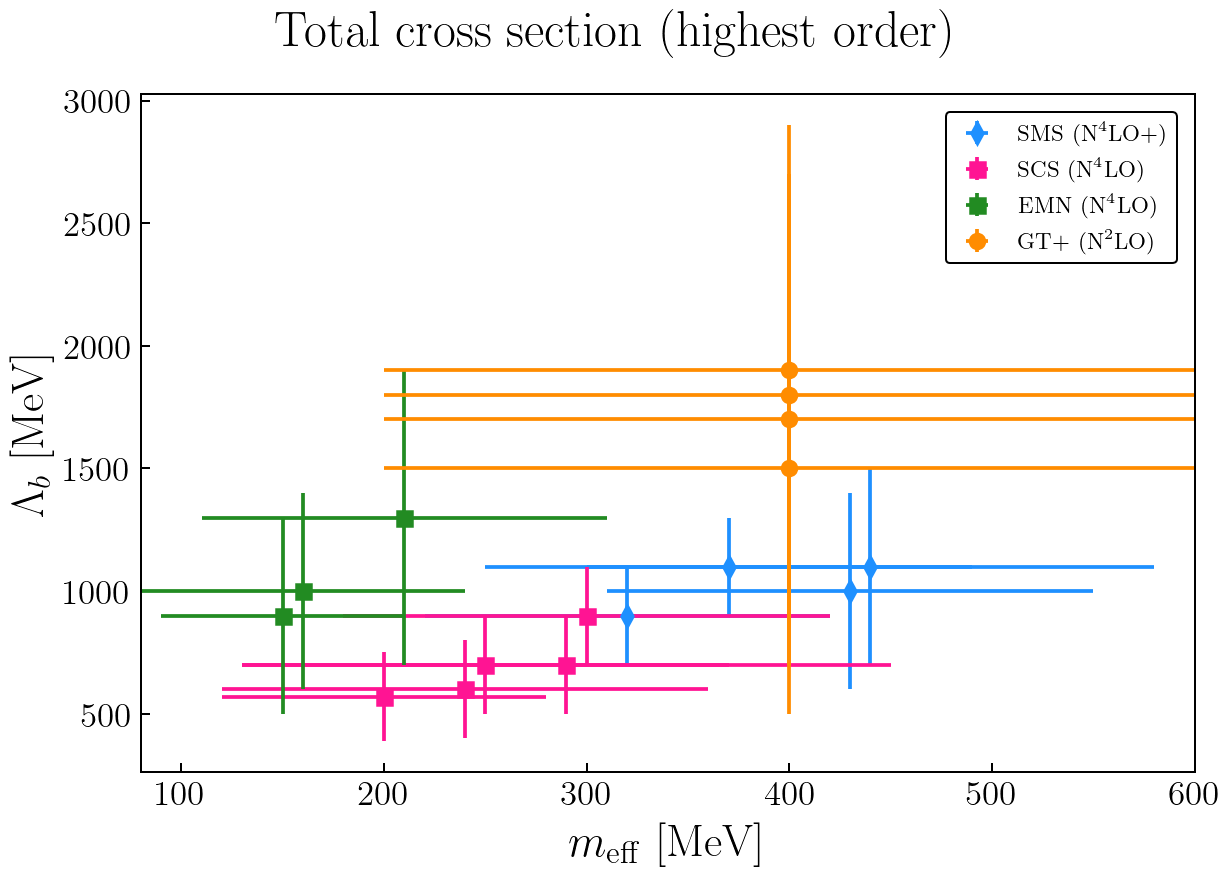

In [10]:
fig_fit_sgt_ho, ax_fit_sgt_ho = plt.subplots(figsize=(7,5))

# groups the data by potential, cutoff, and observable
pot_cutoff_combo = lambda_meff_df[lambda_meff_df["Observable(s)"] == "SGT"].groupby(['Potential', 'Cutoff']).head(1)
for index, row in pot_cutoff_combo.iterrows():
    # scatter-plots the means and 95% (2 sigma) confidence intervals for the scale values
    ax_fit_sgt_ho.errorbar(row["meff_mean"], row["Lambdab_mean"], 
                    xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
                    color = potential_color_dict[row["Potential"]], 
                    label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
                    fmt = order_marker_dict[row["Max. order"]])

fig_fit_sgt_ho.suptitle("Total cross section (highest order)", fontsize = 20)
ax_fit_sgt_ho.set_xlabel("$m_{\mathrm{eff}}$ [MeV]", fontsize = 18)
ax_fit_sgt_ho.set_ylabel(r"$\Lambda_{b}$ [MeV]", fontsize = 18)
ax_fit_sgt_ho.legend(
            fontsize = 10,
          loc='center left',
          bbox_to_anchor=(1, 0.5),
          handletextpad=0.02,
          borderpad=0.2)

legend_without_duplicate_labels(ax_fit_sgt_ho)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig_fit_sgt_ho.tight_layout()
plt.show()
fig_fit_sgt_ho.savefig('figures2/' + 'Lambdab_vs_meff_sgt_ho')

## Plots of length scale and variance by order for different potentials

#### Sets meshes and extracts coefficients from the data for a particular observable and potential

In [11]:
# sets the potential of interest
ScaleScheme = RKE500MeV

In [12]:
# choose energy and angle meshes
t_lab = ScaleScheme.get_data("t_lab")

t_lab_slice_pts = np.array([1, 5, 12, 21, 33, 48, 65, 85, 
                            108, 133, 161, 192, 225, 261, 300, 341])
t_lab_input = E_to_p(E_lab = t_lab, interaction = "np")
# X_train_tlab = E_to_p(E_lab = np.array([5, 21, 48, 85, 133, 192, 261]), 
#                      interaction = "np")[:, None]
# X_train_tlab = E_to_p(E_lab = np.array([1, 12, 33, 65, 108, 161, 225, 300]), 
#                      interaction = "np")[:, None]
X_train_tlab = E_to_p(E_lab = t_lab_slice_pts, 
                     interaction = "np")[:, None]
t_lab_label = "Relative momentum (MeV)"
t_lab_name = "prel"
# t_lab_input = t_lab
# X_train_tlab = np.array([5, 21, 48, 85, 133, 192, 261])[:, None]
# t_lab_label = "Lab energy (MeV)"

X_tlab = t_lab_input[:, None]
# t_lab_subset = t_lab_input[0::10]
t_lab_subset = X_train_tlab[:, 0]

degrees = ScaleScheme.get_data("degrees")

degrees_slice_pts = np.array([41, 60, 76, 90, 104, 120, 139])
# degrees_input = degrees
# X_train_deg = np.array([1, 30, 60, 90, 120, 150, 179])[:, None]
# degrees_label = "Scattering angle (degrees)"
degrees_input = -np.cos(np.radians(degrees))
# X_train_deg = -np.cos(np.radians(np.array([1, 30, 60, 90, 120, 150, 179])))[:, None]
X_train_deg = -np.cos(np.radians(degrees_slice_pts))[:, None]
degrees_label = "Negative cosine"
degrees_name = "cos"

X_deg = degrees_input[:, None]
# degrees_subset = degrees_input[0::10]
degrees_subset = X_train_deg[:, 0]

# sets the observable of interest
obs_data_name = "DSG"

# extracts data
if obs_data_name == "AY":
    obs_data = ScaleScheme.get_data("PB")
else:
    obs_data = ScaleScheme.get_data(obs_data_name)

# sets values of the breakdown and soft scales
Lambda_b_coeffs = 570
mpi_eff_coeffs = 138

# sets reference scale
if obs_data_name == "DSG":
    yref = obs_data[-1, :, :]
#     print("yref has shape " + str(np.shape(yref)))
#     yref = np.tile(2 * np.pi * np.trapz(obs_data[-1, :, :] * np.tile(np.sin(np.radians(degrees)), (len(t_lab), 1)), 
#                                 np.radians(degrees), axis = 1), (len(degrees), 1)).T
#     print("yref has shape " + str(np.shape(yref)))
#     print("yref = " + str(yref))
#     print("SGT = " + str(ScaleScheme.get_data("SGT")[-1, ...]))
else:
    yref = np.ones(np.shape(obs_data)[1:])
    
# # addresses Daniel's request for this
# square_integral_yref = (2 * np.pi * np.trapz(yref * np.tile(np.sin(np.radians(degrees)), (len(t_lab), 1)), 
#                                 np.radians(degrees), axis = 1))**(2)
# # print(square_integral_yref)
# # print(ScaleScheme.get_data("SGT")[-1])
# integral_square_yref = 2 * np.pi * np.trapz((yref)**(2) * np.tile(np.sin(np.radians(degrees)), (len(t_lab), 1)), 
#                                 np.radians(degrees), axis = 1)
# # print(integral_square_yref)

# calculates ratio
p_type = "pprel"
p_grid = p_approx(p_name = p_type, 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = degrees).T
Q_type = "sum"
ratio = Q_approx(p = p_grid, 
                 Q_parametrization = Q_type, 
                 Lambda_b = Lambda_b_coeffs, 
                 m_pi = mpi_eff_coeffs,
                 single_expansion=False)

# extracts coefficients
coeffs_flattened = gm.coefficients(
            np.reshape(obs_data, (np.shape(obs_data)[0], np.shape(obs_data)[1] * np.shape(obs_data)[2])).T, 
            ratio=np.reshape(ratio, np.shape(ratio)[0] * np.shape(ratio)[1]),
            ref=np.reshape(yref, np.shape(yref)[0] * np.shape(yref)[1]), 
            orders=ScaleScheme.orders_full)
coeffs_surfaces = np.reshape(coeffs_flattened.T, np.shape(obs_data))

#### Plots of total cross section for given $\Lambda_{b}$ and $m_{\text{eff}}$

In [13]:
# colors_array = ['orange', 'green', 'blue', 'red', 'purple']

# fig_sgt, ax_sgt = plt.subplots()

# SGT_data = ScaleScheme.get_data("SGT")

# p_grid_sgt = p_approx(p_name = "pprel", 
#                  prel = E_to_p(E_lab = t_lab, interaction = "np"), 
#                  degrees = [0]).T
# ratio_sgt = Q_approx(p = p_grid_sgt, 
#                  Q_parametrization = 'sum', 
# #                  Lambda_b = 725, 
# #                  m_pi = 345,
#                  Lambda_b = 695, 
#                  m_pi = 250,
#                  single_expansion=False)

# yref_sgt = SGT_data[-1, :]

# SGT_coeffs = gm.coefficients(
#             SGT_data.T, 
#             ratio=np.reshape(ratio_sgt, np.shape(ratio_sgt)[0] * np.shape(ratio_sgt)[1]),
#             ref=np.reshape(yref_sgt, np.shape(yref_sgt)[0]), 
#             orders=ScaleScheme.orders_full)
# SGT_coeffs = SGT_coeffs.T

# # set a limit on x
# # print([t > 138 for t in t_lab_input])
# t_lab_input_limit = t_lab_input[t_lab_input > 0]

# for i, curve in enumerate(SGT_coeffs[1:, :]):
#     ax_sgt.plot(t_lab_input_limit, curve[np.isin(t_lab_input, t_lab_input_limit)], 
#                 color = colors_array[i], linewidth = 2)

#### Plots ratios of variances for each 2D observable

[]

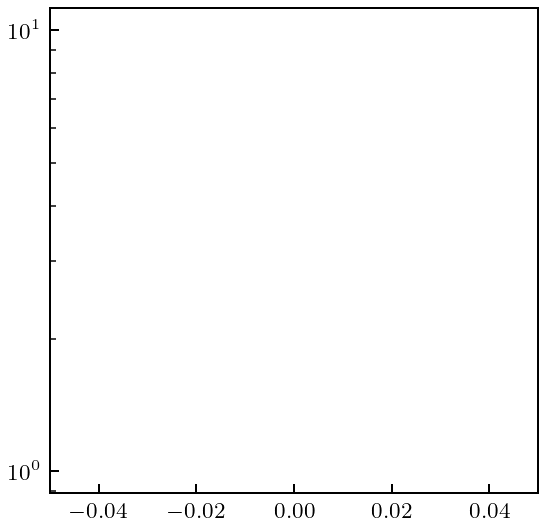

In [14]:
# create figure with n_orders subplots
fig_tlab_var_all_ratio, axs_tlab_var_all_ratio = plt.subplots(1, 1, 
                                                              figsize=(3.5,3.5))
axs_tlab_var_all_ratio.semilogy()

In [15]:
# this section uses all the same input spaces and training points as the rest of the notebook

Lambda_b_vars = Lambda_b_coeffs
mpi_eff_vars = Lambda_b_coeffs

# calculates ratio
p_type_vars = p_type
p_grid_vars = p_approx(p_name = p_type_vars, 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = degrees).T
Q_type_vars = Q_type
ratio_vars = Q_approx(p = p_grid_vars, 
                 Q_parametrization = Q_type_vars, 
                 Lambda_b = Lambda_b_vars, 
                 m_pi = mpi_eff_vars,
                 single_expansion=False)

In [16]:
axs_tlab_var_all_array = np.array([])

# names and labels observbales
obs_data_name_list = ["DSG", "D", "AXX", "AYY", "A", "PB"]
obs_data_label_list = [r"$\frac{d \sigma}{d \Omega}$", 
                       r"$D$", r"$A_{xx}$", r"$A_{yy}$", r"$A$", r"$A_{y}$"]

for idx, obs_data_name_vars in enumerate(obs_data_name_list):
    # extracts data
    obs_data_vars = ScaleScheme.get_data(obs_data_name_vars)
    
    # sets reference scale
    if obs_data_name_vars == "DSG":
        yref_vars = obs_data_vars[-1, :, :]
    else:
        yref_vars = np.ones(np.shape(obs_data_vars)[1:])

    # extracts coefficients
    coeffs_flattened_vars = gm.coefficients(
                np.reshape(obs_data_vars, (np.shape(obs_data_vars)[0], np.shape(obs_data_vars)[1] * np.shape(obs_data_vars)[2])).T, 
                ratio=np.reshape(ratio_vars, np.shape(ratio_vars)[0] * np.shape(ratio_vars)[1]),
                ref=np.reshape(yref_vars, np.shape(yref_vars)[0] * np.shape(yref_vars)[1]), 
                orders=ScaleScheme.orders_full)
    coeffs_surfaces_vars = np.reshape(coeffs_flattened_vars.T, np.shape(obs_data_vars))

    # fits a GP to the coefficients
    for t in t_lab_subset:
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                          length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                               2 * (np.max(degrees_input) - np.min(degrees_input)))
                   ) + WhiteKernel(1e-5, noise_level_bounds='fixed'), 
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        gp.fit(X_train_deg, 
               np.reshape(coeffs_surfaces_vars[:, np.isin(t_lab_input, t), :].T, 
                          (len(degrees), 
                           np.shape(coeffs_surfaces_vars)[0]))[np.isin(degrees_input, X_train_deg), :])
        pred, std = gp.predict(X_deg, return_std=True)
        # extracts a value of the variance and adds it to an array
        underlying_std = gp.cov_factor_
        axs_tlab_var_all_array = np.append(axs_tlab_var_all_array, underlying_std)
        
axs_tlab_var_all_array = np.reshape(axs_tlab_var_all_array, 
                                    (len(obs_data_name_list), len(t_lab_subset)))

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.70277009e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.40570293e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 39, 'nit': 4, 'warnfla

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.26200864e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 39, 'nit': 6, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.42372373e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 40, 'nit': 7, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.11369726e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 37, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b t

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.17962695e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 35, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.64617081e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.65466723e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 42, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b t

In [17]:
# for each observable, plots the ratio of the largest variance extracted to the smallest, 
# with options for excluding data from the sample
axs_tlab_var_all_ratio.scatter(list(range(len(obs_data_name_list))), 
    [np.max(axs_tlab_var_all_array[l, :]) / np.min(axs_tlab_var_all_array[l, :]) for l in range(len(axs_tlab_var_all_array))], 
    marker = 'o', 
    edgecolors = 'green',
    label = r'$Q_{\mathrm{sum}}(p_{\mathrm{rel}} \geq 25\,\mathrm{MeV}, m_{\pi}^{\star}, \Lambda_{b}^{\star})$',
#     edgecolors = 'green', 
#     label = r'2D ALLOBS, all $p_{\mathrm{rel}} > 25\,\mathrm{MeV}$',
    linewidths = 2,
    s = 90, 
    facecolors = 'none')
axs_tlab_var_all_ratio.scatter(list(range(len(obs_data_name_list))), 
    [np.max(axs_tlab_var_all_array[l, 4:]) / np.min(axs_tlab_var_all_array[l, 4:]) for l in range(len(axs_tlab_var_all_array))], 
    marker = 's', 
#     c = 'red', 
#     label = r'OPAAT, $p_{\mathrm{rel}} > 125\,\mathrm{MeV}$', 
    c = 'green', 
    label = r'$Q_{\mathrm{sum}}(p_{\mathrm{rel}} \geq 125\,\mathrm{MeV}, m_{\pi}^{\prime}, \Lambda_{b}^{\prime})$',
    s = 90)
axs_tlab_var_all_ratio.legend(loc = 'upper right', 
                              fontsize = 10,
                              handletextpad=0.02,
                              borderpad=0.2)

axs_tlab_var_all_ratio.set_xticklabels([""] + obs_data_label_list + [""], fontsize = 10)
axs_tlab_var_all_ratio.tick_params(axis = 'y', labelsize = 10)
axs_tlab_var_all_ratio.set_xlim(-1, len(obs_data_name_list))
axs_tlab_var_all_ratio.set_ylim(0.9, 160)

# saves figures
fig_tlab_var_all_ratio.savefig('figures2/' + 'var_ratios' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string)

C:\Users\pjmil\AppData\Local\Temp\ipykernel_30296\2519844871.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs_tlab_var_all_ratio.set_xticklabels([""] + obs_data_label_list + [""], fontsize = 10)


#### Plots of scattering-angle length scale and variance by order

C:\Users\pjmil\AppData\Local\Temp\ipykernel_30296\1227354476.py:59: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_tlab_ls.flat)[o].scatter(t,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_30296\1227354476.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_tlab_var.flat)[o].scatter(t,
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated

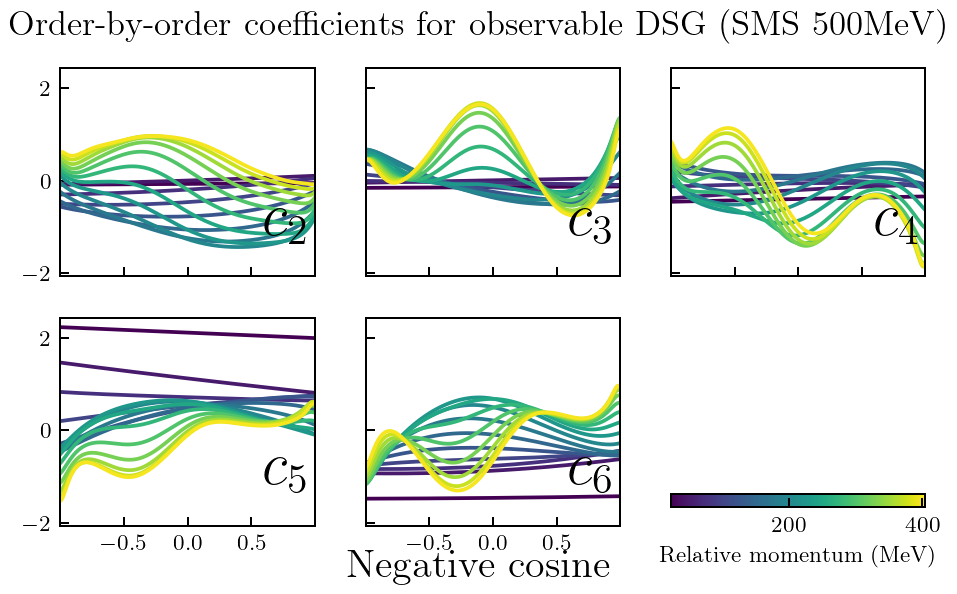

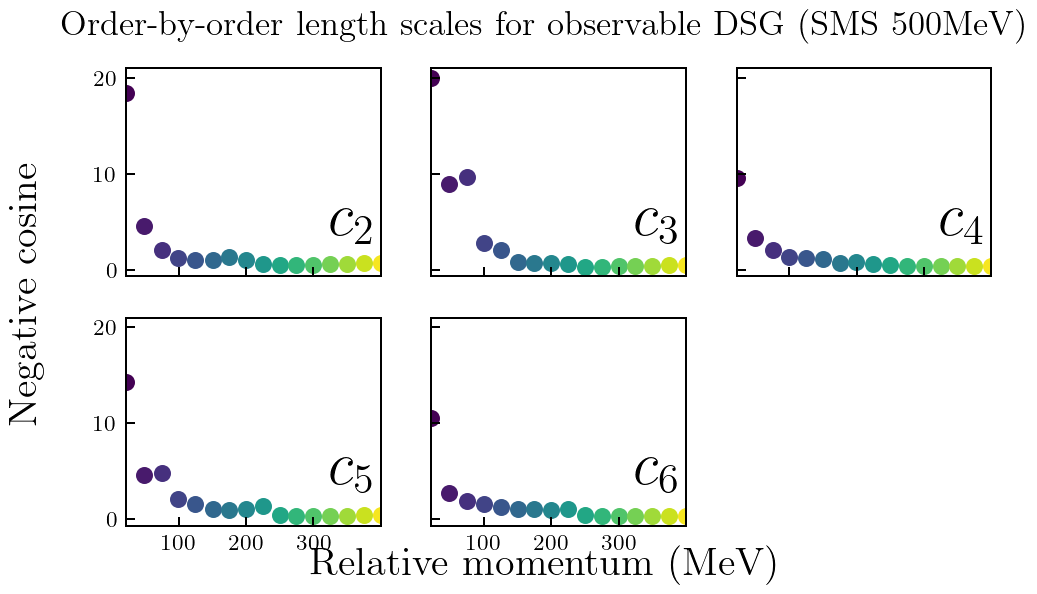

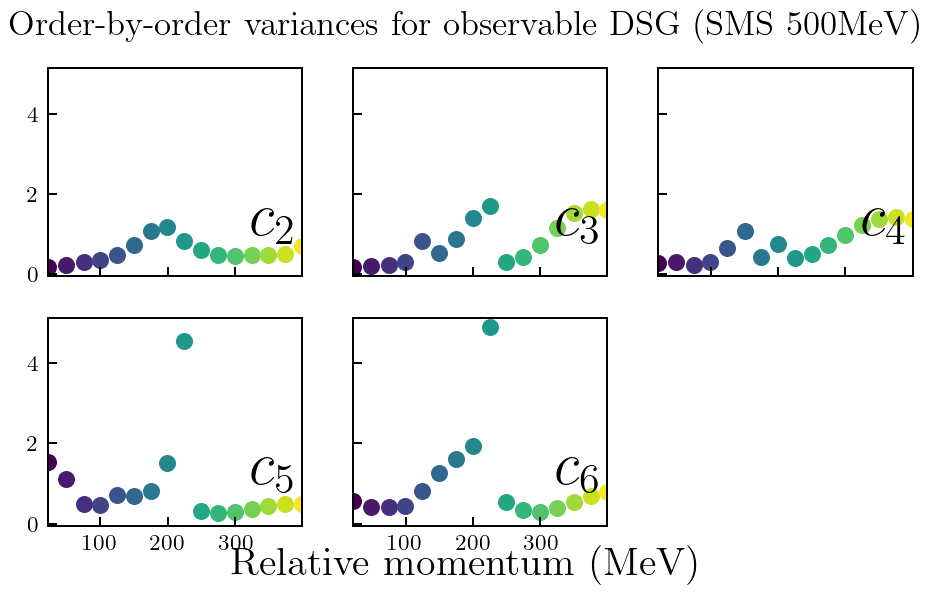

In [18]:
# choose colormap and fix to different energies
cmap_tlab = mpl.cm.viridis
norm_tlab = mpl.colors.Normalize(vmin=np.min(t_lab_input), vmax=np.max(t_lab_input))

# create figure with n_orders subplots
fig_tlab_coeffs, axs_tlab_coeffs = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_tlab_coeffs.supxlabel(degrees_label, size = 16)
fig_tlab_coeffs.suptitle('Order-by-order coefficients for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# create figure with n_orders subplots
fig_tlab_ls, axs_tlab_ls = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_tlab_ls.supxlabel(t_lab_label, size = 16)
fig_tlab_ls.supylabel(degrees_label, size = 16)
fig_tlab_ls.suptitle('Order-by-order length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# create figure with n_orders subplots
fig_tlab_var, axs_tlab_var = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_tlab_var.supxlabel(t_lab_label, size = 16)
fig_tlab_var.suptitle('Order-by-order variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# plot at each energy in mesh
for o in range(np.shape(coeffs_surfaces)[0] - 1):
    (axs_tlab_coeffs.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_coeffs.flat)[o].transAxes, 
                       size = 24)
    (axs_tlab_ls.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_ls.flat)[o].transAxes, 
                       size = 24)
    (axs_tlab_var.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_var.flat)[o].transAxes, 
                       size = 24)
        
    for t in t_lab_subset:
        (axs_tlab_coeffs.flat)[o].plot(degrees_input, 
                    coeffs_surfaces[o + 1, np.isin(t_lab_input, t), :].T, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                      length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                           10 * (np.max(degrees_input) - np.min(degrees_input)))
               ) + WhiteKernel(1e-5, noise_level_bounds='fixed'),
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        gp.fit(X_train_deg, 
               (coeffs_surfaces[o + 1, np.isin(t_lab_input, t), :].T)[np.isin(degrees_input, X_train_deg)])
        ls_fit = np.exp(gp.kernel_.theta)
        (axs_tlab_ls.flat)[o].scatter(t, 
                    ls_fit, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        
        pred, std = gp.predict(X_deg, return_std=True)
        underlying_std = gp.cov_factor_
        (axs_tlab_var.flat)[o].scatter(t, 
                    underlying_std, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))

# eliminates any extraneous Axes objects
fig_tlab_coeffs.delaxes(axs_tlab_coeffs[-1, -1])        
fig_tlab_coeffs.colorbar(mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab), 
            ax = axs_tlab_coeffs[-1, -1],
             orientation='horizontal', label=t_lab_label)

fig_tlab_ls.delaxes(axs_tlab_ls[-1, -1])
fig_tlab_var.delaxes(axs_tlab_var[-1, -1])

# saves figures
fig_tlab_coeffs.savefig('figures2/' + 'coeffs' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_tlab_ls.savefig('figures2/' + 'ls' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_tlab_var.savefig('figures2/' + 'var' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

#### Plots of scattering-angle length scale and variance over all orders

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.48607282e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 35, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.63708532e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 37, 'nit': 6, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.29133405e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 34, 'nit': 3, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b ter

[ 21.65954334  48.43221129  75.03085916 124.42460409 150.06171898
 174.62482246 199.69112475 225.09258005 249.79004319 274.82880024
 300.12344279 324.89315826 349.92064163 375.15430749 399.96915557]
offset = 0.4369833286608192 +/- 0.07981843683048039
scaling = 1.5599761665719232e-06 +/- 1.0023488612263982e-06


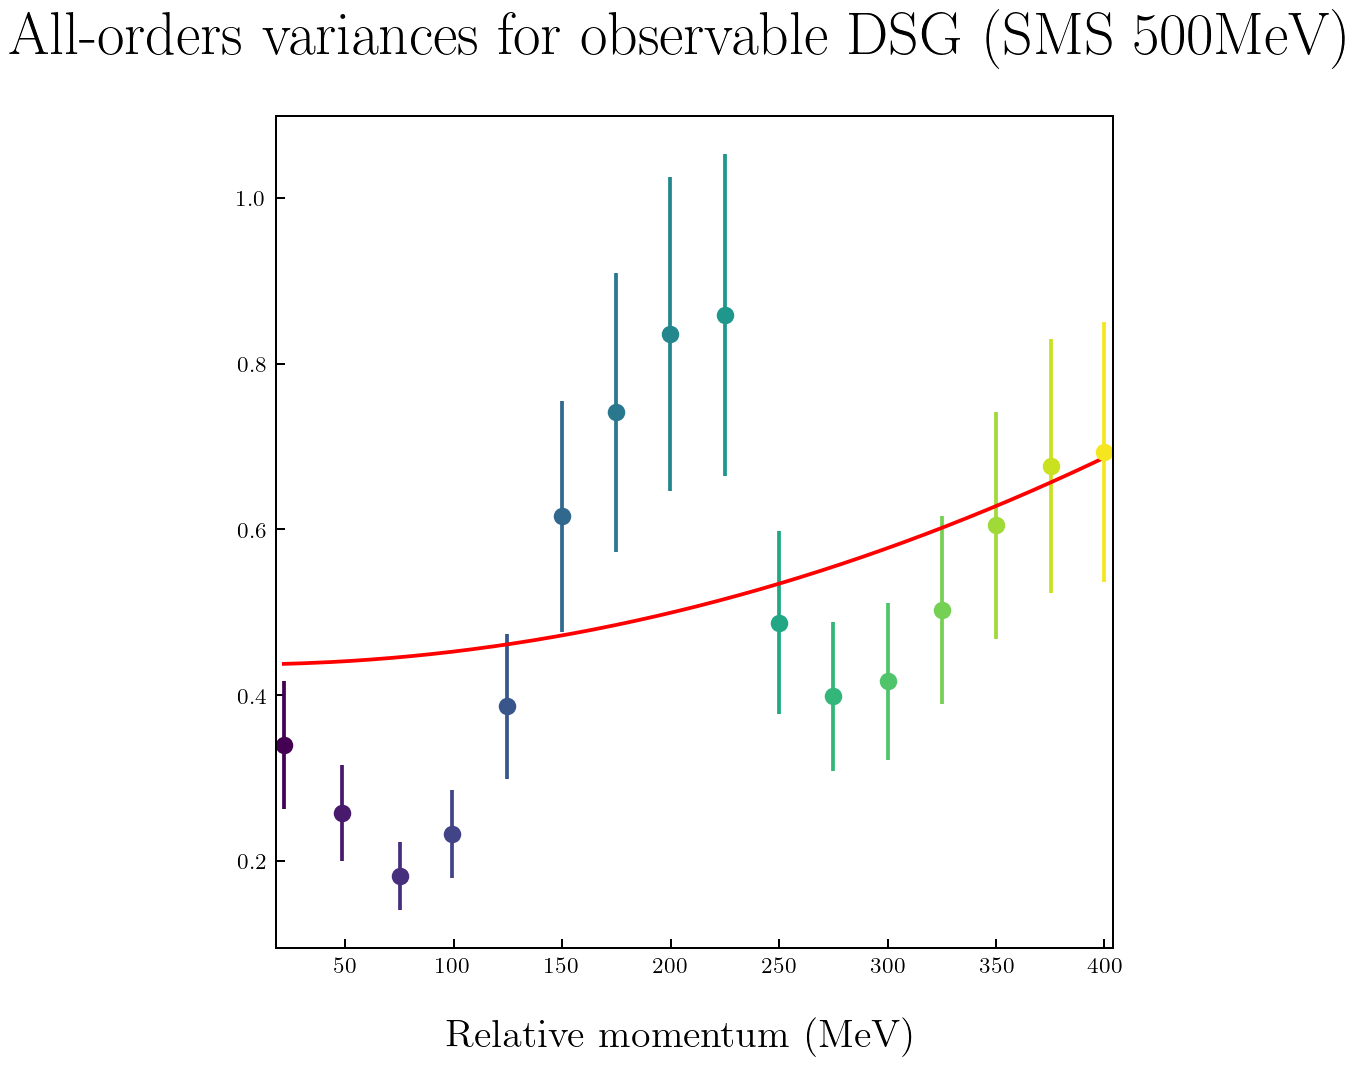

In [19]:
# create figure with n_orders subplots
fig_tlab_var_all, axs_tlab_var_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_tlab_var_all.supxlabel(t_lab_label, size = 16)
fig_tlab_var_all.suptitle('All-orders variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_tlab_var_all.semilogx()
# axs_tlab_var_all.semilogy()

axs_tlab_var_all_array = np.array([])
axs_tlab_var_all_stddev_array = np.array([])

def power_with_offset(x, a, b):
    return a + b * x**(2)

# plots at each energy in mesh
for t in t_lab_subset:
    gp = gm.ConjugateGaussianProcess(
        RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                      length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                           10 * (np.max(degrees_input) - np.min(degrees_input)))
               ) + WhiteKernel(1e-5, noise_level_bounds='fixed'), 
        center=0, 
        disp=0, 
        df=1,
        scale=1, 
        n_restarts_optimizer=100, 
        random_state=None,
        sd=None)
    gp.fit(X_train_deg, 
           np.reshape(coeffs_surfaces[:, np.isin(t_lab_input, t), :].T, 
                      (len(degrees), 
                       np.shape(coeffs_surfaces)[0]))[np.isin(degrees_input, X_train_deg), :])
#     ls_fit = np.exp(gp.kernel_.theta)
#     mean_test, stddev_test = mean_and_stddev(gp.ls_input_values, gp.ls_lml_values)
#     print(mean_test)
#     print(stddev_test)
#     ls_opt_array = np.exp(np.concatenate(gp.ls_optima_values[:, 0]).ravel())
#     print(ls_opt_array)
#     print(np.std(ls_opt_array))
#     axs_tlab_ls_all.scatter(t, 
#                 ls_fit, 
#                 c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
#     axs_tlab_ls_all_array = np.append(axs_tlab_ls_all_array, ls_fit)
#     pred, std = gp.predict(X_deg, return_std=True)
    # extracts the variance
    underlying_std = gp.cov_factor_
    # calculates the 1-sigma error bars on the variance
    stddev_underlying_std = underlying_std * np.sqrt(2 / (gp.df_ - 4))
    # plots variance with 1-sigma error bars
    axs_tlab_var_all.errorbar(t, 
                underlying_std, 
                yerr = stddev_underlying_std,
                c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t), 
                fmt = 'o')
    # appends variance values to an array
    axs_tlab_var_all_array = np.append(axs_tlab_var_all_array, underlying_std)
    axs_tlab_var_all_stddev_array = np.append(axs_tlab_var_all_stddev_array, stddev_underlying_std)

# eliminates an outlier for fitting
outlier_mask = np.ones(len(t_lab_subset), dtype = bool)
outlier_mask[3] = False
print(t_lab_subset[outlier_mask])

# fits the points to a line
popt, pcov = scipy.optimize.curve_fit(power_with_offset, t_lab_subset[outlier_mask], 
                                    axs_tlab_var_all_array[outlier_mask], 
#                                     sigma = axs_tlab_var_all_stddev_array
                                     )

# plots the line of best fit
axs_tlab_var_all.plot(t_lab_input, 
            power_with_offset(t_lab_input, popt[0], popt[1]), 
            color = "red", 
#            label = orders_labels_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_ell + o_idx + 1] + 
# #                     rf": $\Lambda_{{b}} = {popt[0]:3.0f}\,\mathrm{{MeV}}, m_{{\mathrm{{eff}}}} = {popt[1]:3.0f}\,\mathrm{{MeV}}$", 
#             rf": $({popt[0]:2.0f} \pm {np.sqrt(pcov[0, 0]):2.0f}) x \wedge ({popt[1]:1.1f} \pm {np.sqrt(pcov[1, 1]):1.1f})$", 
            )
# prints the best fit values
print("offset = " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0, 0])))
print("scaling = " + str(popt[1]) + " +/- " + str(np.sqrt(pcov[1, 1])))
# print("power = " + str(popt[2]) + " +/- " + str(np.sqrt(pcov[2, 2])))

axs_tlab_var_all.set_xlim(left = np.min(t_lab_subset) - 0.01 * (np.max(t_lab_subset) - np.min(t_lab_subset)), 
                         right = np.max(t_lab_subset) + 0.01 * (np.max(t_lab_subset) - np.min(t_lab_subset)))

# saves figures
fig_tlab_var_all.savefig('figures2/' + 'var' + '_' + 'tlab_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

In [20]:
# fig_tlab_var_all_yref, axs_tlab_var_all_yref = plt.subplots(1, 2, 
#                     sharex = True, sharey=False, figsize=(12, 6))
# axs_tlab_var_all_yref[0].set_xlabel(t_lab_label, size = 16)
# axs_tlab_var_all_yref[1].set_xlabel(t_lab_label, size = 16)
# fig_tlab_var_all_yref.suptitle('All-orders variances for observable ' + obs_data_name + " (" + 
#              ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ") with reference scale", size = 24)
# axs_tlab_var_all_yref[0].scatter(t_lab_subset, 
#             integral_square_yref[np.isin(t_lab_input, t_lab_subset)])
# axs_tlab_var_all_yref[1].scatter(t_lab_subset, 
#             square_integral_yref[np.isin(t_lab_input, t_lab_subset)])
# print(integral_square_yref[np.isin(t_lab_input, t_lab_subset)])
# print(square_integral_yref[np.isin(t_lab_input, t_lab_subset)])

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:52:58,327	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 11.589818
Observable DSG, variable lsdeg: mean = 11.868932291743725
Observable DSG, variable lsdeg: std. dev. = 1.8466124172507656


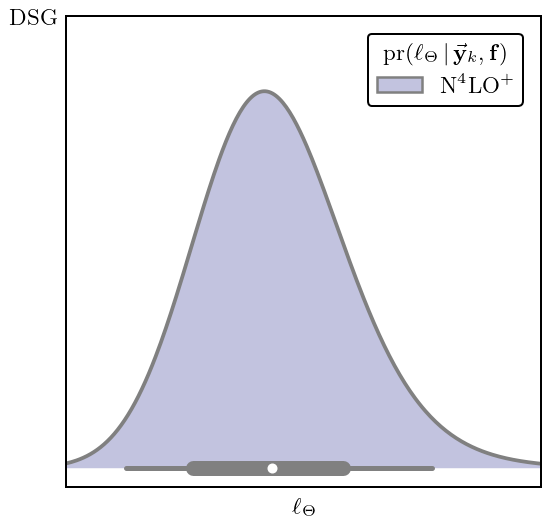

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:53:07,753	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 3.3027835
Observable DSG, variable lsdeg: mean = 3.4340963062677505
Observable DSG, variable lsdeg: std. dev. = 0.5099578252027143


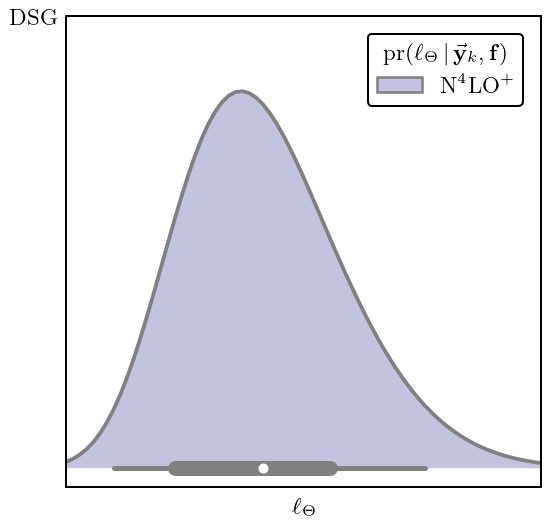

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:53:16,385	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 2.3419678
Observable DSG, variable lsdeg: mean = 2.316069904137784
Observable DSG, variable lsdeg: std. dev. = 0.2729431758559062


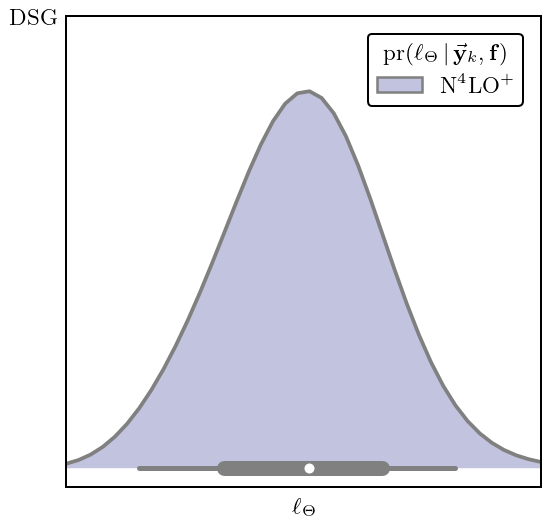

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:53:26,934	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 1.5412883
Observable DSG, variable lsdeg: mean = 1.5687984681721472
Observable DSG, variable lsdeg: std. dev. = 0.1412923555424581


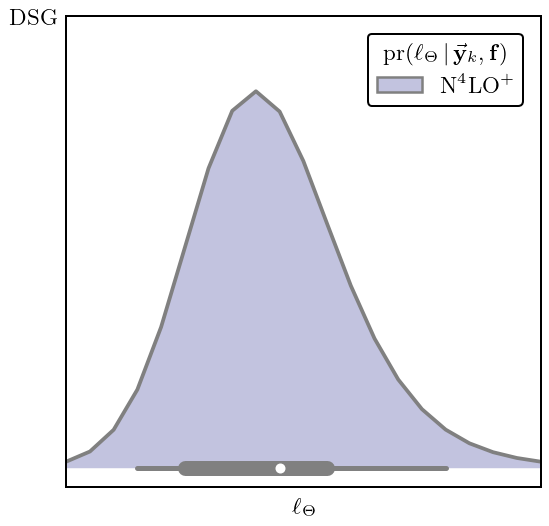

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:53:37,786	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 1.3411183
Observable DSG, variable lsdeg: mean = 1.3037297839366047
Observable DSG, variable lsdeg: std. dev. = 0.17000222136999893


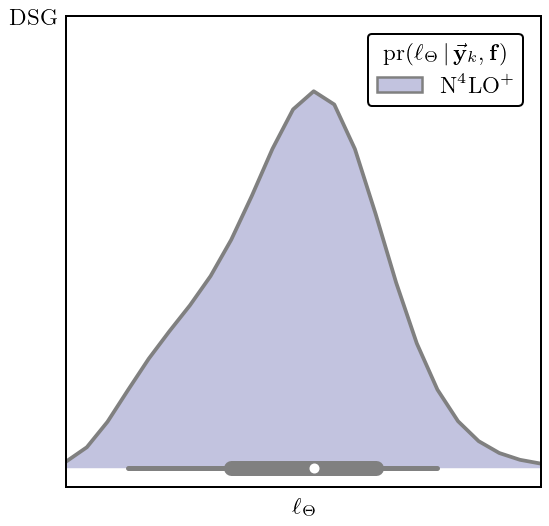

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:53:48,955	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 0.94077855
Observable DSG, variable lsdeg: mean = 1.031482916641479
Observable DSG, variable lsdeg: std. dev. = 0.17272917388803086


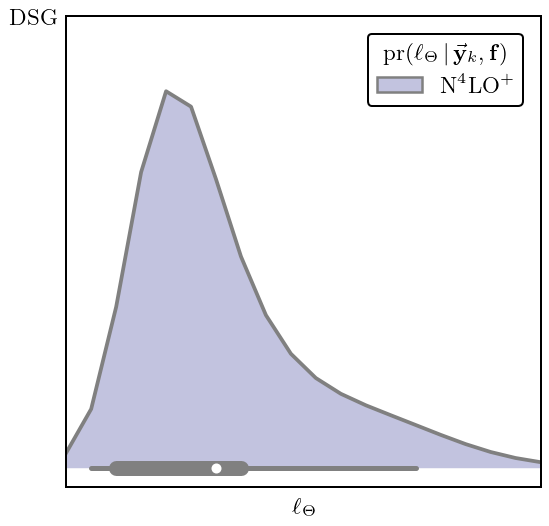

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:53:59,759	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 0.94077855
Observable DSG, variable lsdeg: mean = 0.9790946950975032
Observable DSG, variable lsdeg: std. dev. = 0.10967808311860382


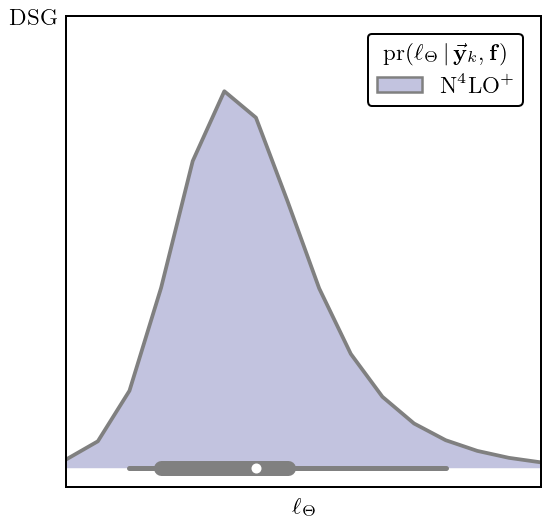

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:54:10,106	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 0.90074456
Observable DSG, variable lsdeg: mean = 0.8812697955064424
Observable DSG, variable lsdeg: std. dev. = 0.1033388292804204


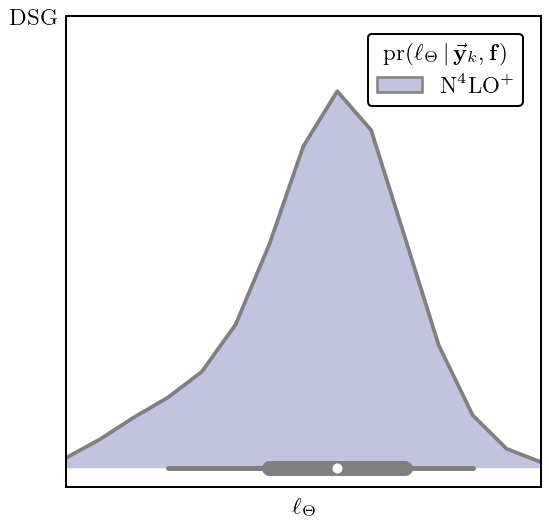

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:54:21,068	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 0.5804727
Observable DSG, variable lsdeg: mean = 0.5636316155466364
Observable DSG, variable lsdeg: std. dev. = 0.04520269439440408


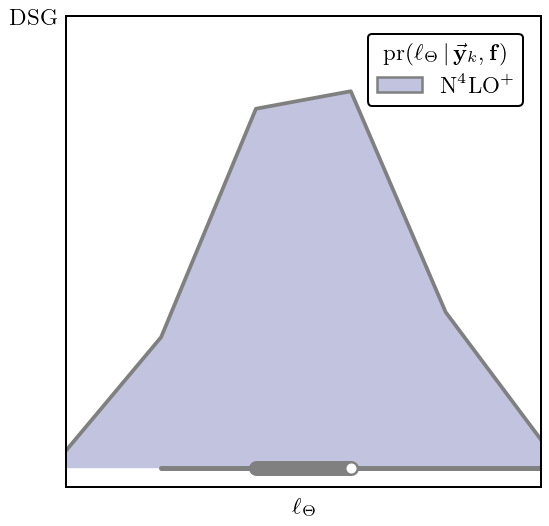

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:54:32,365	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 0.46037075
Observable DSG, variable lsdeg: mean = 0.4574352463731012
Observable DSG, variable lsdeg: std. dev. = 0.033352897429081874


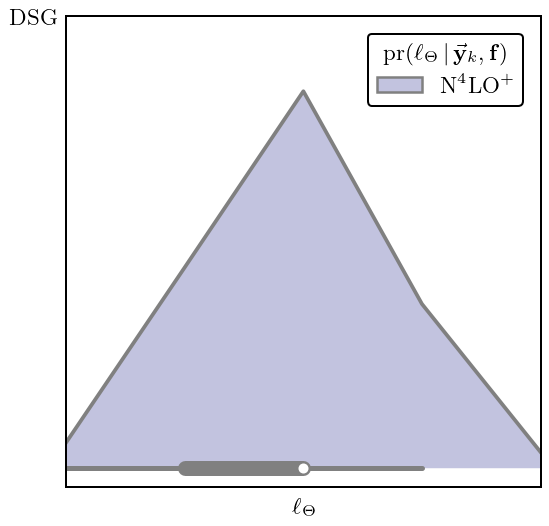

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:54:46,395	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 0.3803028
Observable DSG, variable lsdeg: mean = 0.39122709163825886
Observable DSG, variable lsdeg: std. dev. = 0.032025884183526136


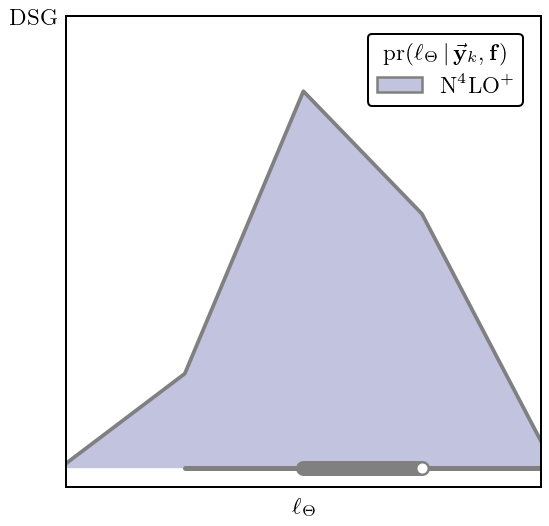

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:54:57,687	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 0.3803028
Observable DSG, variable lsdeg: mean = 0.3728077840020865
Observable DSG, variable lsdeg: std. dev. = 0.030086418981689237


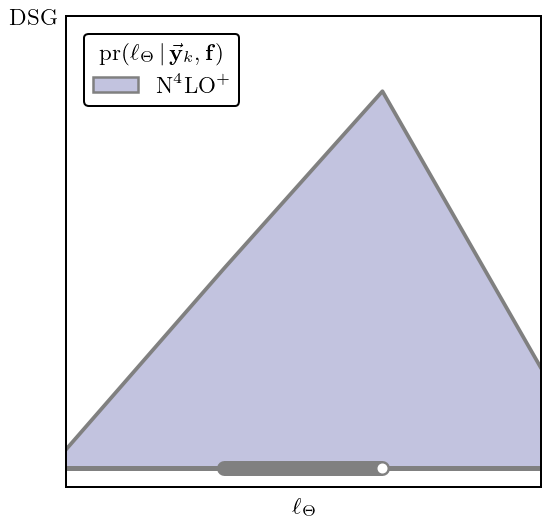

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:55:09,346	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 0.3803028
Observable DSG, variable lsdeg: mean = 0.381615948320158
Observable DSG, variable lsdeg: std. dev. = 0.02904737247730019


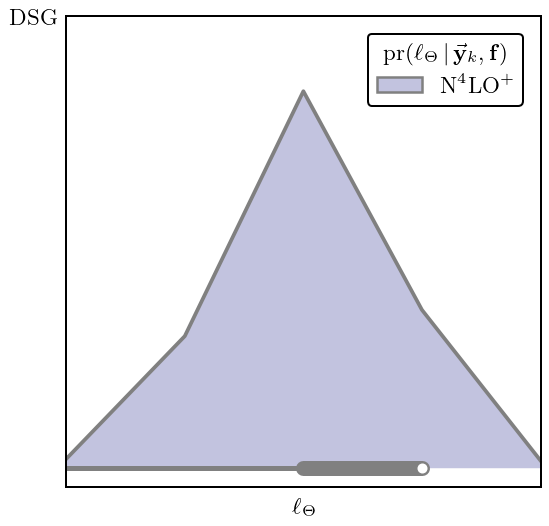

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:55:21,166	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 0.3803028
Observable DSG, variable lsdeg: mean = 0.39653605602313063
Observable DSG, variable lsdeg: std. dev. = 0.03349485662693442


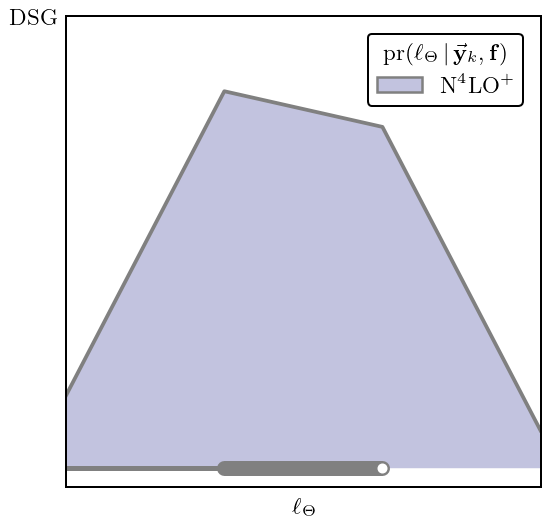

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:55:33,373	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 0.42033678
Observable DSG, variable lsdeg: mean = 0.40735326786830267
Observable DSG, variable lsdeg: std. dev. = 0.032462617896951845


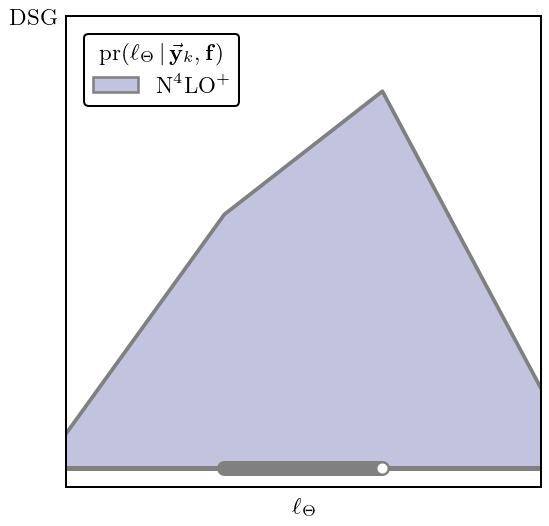

['$', None, '(\\theta, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(q_{\\mathrm{cm}}^{2}, E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(\\mathrm{sin}(\\theta), E_{\\mathrm{lab}}= ', None, '\\,\\mathrm{MeV})$']
['$', None, '(E_{\\mathrm{lab}})$']
['$', None, '(p_{\\mathrm{rel}})$']


2024-03-27 14:55:45,066	INFO worker.py:1553 -- Started a local Ray instance.


Observable DSG, variable lsdeg: MAP value = 0.42033678
Observable DSG, variable lsdeg: mean = 0.4114660085949962
Observable DSG, variable lsdeg: std. dev. = 0.03147278901195099


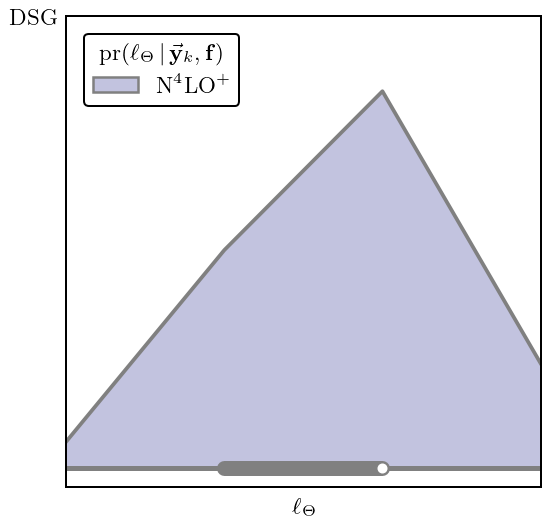

In [22]:
import ray

ScaleSchemeQ_list = [ScaleScheme]

# sets random variables for Bayesian statistical calculations
ls_deg_vals = np.linspace(0.01 * (np.max(degrees_input) - np.min(degrees_input)), 
                          10 * (np.max(degrees_input) - np.min(degrees_input)), 
                          500, dtype=np.dtype('f4'))
mesh_cart_tlabslice = gm.cartesian(np.log(ls_deg_vals))

LsDegVariable = RandomVariable(var=ls_deg_vals,
                            user_val=None,
                            name='lsdeg',
                            label="\ell_{\Theta}",
                            units="",
                            ticks=[],
                            logprior=np.zeros(len(ls_deg_vals)),
                            logprior_name="noprior",
                            marg_bool=True)
variables_array = np.array([LsDegVariable])

# ALLOBS for angle input spaces
plot_obs_list = [[obs_data_name]]
obs_name_grouped_list = [obs_data_name]
obs_labels_grouped_list = [obs_data_name]
mesh_cart_grouped_list = [[mesh_cart_tlabslice]]
# plot_obs_list = [["DSG", "D", "AXX", "AYY", "A", "AY"]]
# obs_name_grouped_list = ["ALLOBS"]
# obs_labels_grouped_list = [r'$\Pi$Obs.']
# mesh_cart_grouped_list = [[mesh_cart_tlabslice, mesh_cart_tlabslice, mesh_cart_tlabslice, 
#                           mesh_cart_tlabslice, mesh_cart_tlabslice, mesh_cart_tlabslice, ]]

# creates a new ratio and log_likelihood function
def ratio_fn_new(X, p_grid_train, p_param, p_shape, Q_param, mpi_var, p, lambda_var, 
                 single_expansion = False):
    """
    Function for interpolating between the input space and the ratio across that input space.

    Parameters
    ----------
    X (array) : array of input-space values. These are never called but must be passed here anyway due to GSUM.
    p_grid_train : array of momenta for evaluating ratio
    p_param (str) : type of p parametrization.
        Can be "Qofprel", "Qofqcm", or "Qofpq"
    p_shape (tuple) : shape for momentum before calculating ratio.
    Q_param (str) : type of Q parametrization.
        Can be "smoothmax", "max", or "sum".
    mpi_var (float) : value of the (effective) pion mass (in MeV) for calculating the ratio.
    lambda_var (float) : value of the breakdown scale (in MeV) for calculating the ratio.
    single_expansion (bool) : if True, then mpi_var is set to 0 within Q_approx
        Default : False
    """
    return Q_approx(p = p, 
                    Q_parametrization=Q_param, Lambda_b = lambda_var, 
                    m_pi = mpi_var, single_expansion=single_expansion)

@ray.remote
def log_likelihood_new(gp_fitted,
                   mesh_points,
                   log_likelihood_fn_kwargs
                   ):
    """
    Calculates the log-likelihood for a set of inputs.

    Parameters
    ----------
    gp_fitted (TruncationGP) : fitted Gaussian process object.
    mesh_points (float array) : array of tuples of random variables at which to evaluate the log-likelihood.
        Must be in the order (lambda_var, all length scales, mpi_var).
    log_likelihood_fn_kwargs (dict) : keyword arguments for log_likelihood.
    """
    return [gp_fitted.log_marginal_likelihood([pt[n] for n in range(len(pt))],
                                              **{**log_likelihood_fn_kwargs}

                                              ) for pt in mesh_points]

ell_fit_pts = np.array([])
ell_fit_stddev = np.array([])

orders_ell = 1

# calculates posterior pdfs for the scattering-angle length scale and extracts values for 
# the MAP, mean, and variance
for elfp, pfp in zip(t_lab_slice_pts, E_to_p(t_lab_slice_pts, interaction = 'np')):
    ratio_fn=ratio_fn_new
    ratio_fn_kwargs={
        "p_param": p_type,
        "Q_param": Q_type,
        "p" : pfp,
        "mpi_var": mpi_eff_coeffs,
        "lambda_var": Lambda_b_coeffs,
        "single_expansion": False,
    }
    log_likelihood_fn=log_likelihood_new
    log_likelihood_fn_kwargs={
        "p_param": p_type,
        "Q_param": Q_type,
        "p" : pfp,
        "mpi_var": mpi_eff_coeffs,
        "lambda_var": Lambda_b_coeffs,
        "single_expansion": False,
    }
    
    stats_array, _ = generate_posteriors(
#         nn_interaction="np",
        scale_scheme_bunch_array=ScaleSchemeQ_list,
        Q_param_method_array=[Q_type],
        p_param_method_array=[p_type],
        input_space_deg=[degrees_name],
        input_space_tlab=[t_lab_name],
        Elab_slice = elfp,
        t_lab_train_pts=np.array([1, 12, 33, 65, 108, 161, 225, 300]),
        degrees_train_pts=degrees_slice_pts,
        orders_from_ho=orders_ell,
        orders_excluded=[],
        orders_names_dict=None,
        orders_labels_dict=None,
        LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 1/25, 40, whether_fit=True),
        LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 1/25, 40, whether_fit=True),
        m_pi_eff=mpi_eff_coeffs,
        Lambdab=Lambda_b_coeffs,
        print_all_classes=False,
        savefile_type="png",

        plot_posterior_curvewise_bool=True,
        plot_corner_curvewise_bool=False,
        use_data_curvewise_bool=False,
        save_data_curvewise_bool=False,
        save_posterior_curvewise_bool=False,

        plot_obs_list = plot_obs_list,
        obs_name_grouped_list = obs_name_grouped_list,
        obs_labels_grouped_list = obs_labels_grouped_list,
        mesh_cart_grouped_list = mesh_cart_grouped_list,
        variables_array_curvewise = variables_array,
        
        ratio_fn_posterior = ratio_fn,
        ratio_fn_kwargs_posterior = ratio_fn_kwargs,
        log_likelihood_fn_posterior = log_likelihood_fn,
        log_likelihood_fn_kwargs_posterior = log_likelihood_fn_kwargs,

        plot_posterior_pointwise_bool=False,
        save_posterior_pointwise_bool=False,

        variables_array_pointwise = np.array([0]),

        filename_addendum="",
    )

    ell_fit_pts = np.append(ell_fit_pts, stats_array[[i % 3 == 0 for i in range(np.shape(stats_array)[0])]])
    ell_fit_stddev = np.append(ell_fit_stddev, stats_array[[i % 3 == 2 for i in range(np.shape(stats_array)[0])]])
# ell_fit_stddev = np.zeros(np.shape(ell_fit_pts))

N4LO+: magnitude = 344.0647077044565 +/- 141.5642440143623
N4LO+: power = -1.173439917592483 +/- 0.07569530118848171



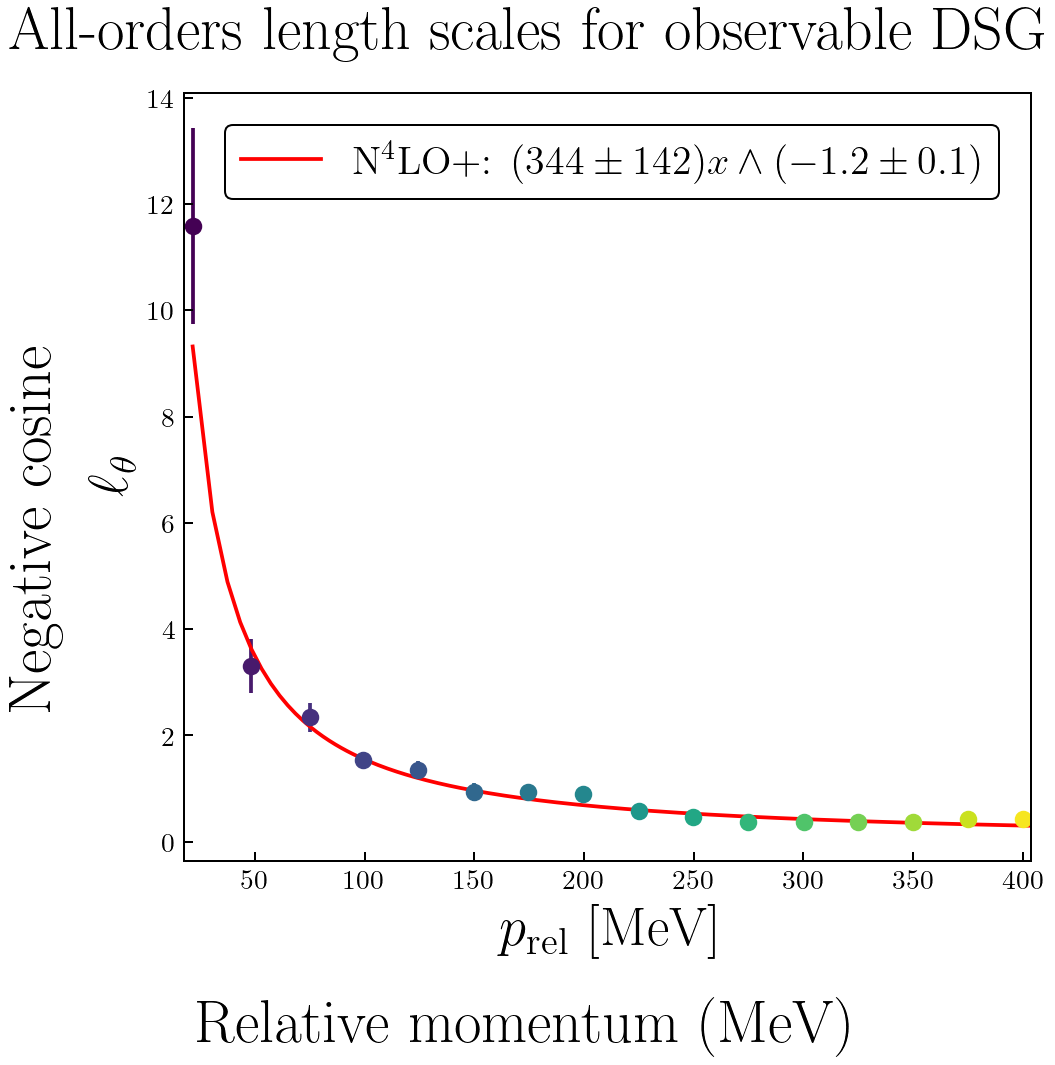

In [32]:
from sklearn.linear_model import LinearRegression

# dicts for orders
orders_labels_dict = {6: r'N$^{4}$LO+', 5: r'N$^{4}$LO',
                    4: r'N$^{3}$LO', 3: r'N$^{2}$LO', 2: r'NLO'}
orders_names_dict = {6: r'N4LO+', 5: r'N4LO', 4: r'N3LO', 3: r'N2LO', 2: r'NLO'}

# sets fitting functions
def power(x, a, b):
    return a * x**b
def exponent(x, a, b):
    return a * np.exp(b * x)

for ss_idx in range(len(ScaleSchemeQ_list)):
    # create figure with n_orders subplots
    fig_tlab_ls_all, axs_tlab_ls_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
    fig_tlab_ls_all.supxlabel(t_lab_label, size = 20)
    fig_tlab_ls_all.supylabel(degrees_label, size = 20)
    fig_tlab_ls_all.suptitle('All-orders length scales for observable ' + obs_data_name \
                + " (" + ScaleScheme.potential_string +  " " + ScaleScheme.cutoff_string + ")"\
                , size = 20)
    # axs_tlab_ls_all.semilogx()
    # axs_tlab_ls_all.semilogy()

    for o_idx in range(orders_ell):
        idx_mask = [i % (orders_ell * len(ScaleSchemeQ_list)) == 
                 (o_idx + ss_idx * orders_ell) for i in range(len(ell_fit_pts))]

        # scatter-plots the means and (1-sigma) confidence intervals for the length scale
        axs_tlab_ls_all_array = ell_fit_pts[idx_mask]
        axs_tlab_ls_all_stddev_array = ell_fit_stddev[idx_mask]
        for t in t_lab_subset:
            axs_tlab_ls_all.errorbar(t, 
                        axs_tlab_ls_all_array[np.isin(t_lab_subset, t)], 
                        yerr = axs_tlab_ls_all_stddev_array[np.isin(t_lab_subset, t)],
                        c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t), 
                        fmt = 'o', 
                       zorder = o_idx)
        # fits the points to a line
        popt, pcov = scipy.optimize.curve_fit(power, t_lab_subset, 
                                            axs_tlab_ls_all_array, 
                                            sigma = axs_tlab_ls_all_stddev_array
                                             )

        # plots the line of best fit
        axs_tlab_ls_all.plot(t_lab_input, 
                    power(t_lab_input, popt[0], popt[1]), 
                    color = "red", 
                   label = orders_labels_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_ell + o_idx + 1] + 
#                     rf": $\Lambda_{{b}} = {popt[0]:3.0f}\,\mathrm{{MeV}}, m_{{\mathrm{{eff}}}} = {popt[1]:3.0f}\,\mathrm{{MeV}}$", 
                    rf": $({popt[0]:2.0f} \pm {np.sqrt(pcov[0, 0]):2.0f}) x \wedge ({popt[1]:1.1f} \pm {np.sqrt(pcov[1, 1]):1.1f})$", 
                    zorder = o_idx)
        # prints the best fit values
        print(orders_names_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_ell + o_idx + 1] + ": magnitude = " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0, 0])))
        print(orders_names_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_ell + o_idx + 1] + ": power = " + str(popt[1]) + " +/- " + str(np.sqrt(pcov[1, 1])) + "\n")

    # fig_fit.suptitle("MAP $Q$ values and lines of fit", fontsize = 20)
    axs_tlab_ls_all.set_xlabel("$p_{\mathrm{rel}}$ [MeV]", fontsize = 16)
    axs_tlab_ls_all.set_xlim(left = np.min(t_lab_subset) - 0.01 * (np.max(t_lab_subset) - np.min(t_lab_subset)), 
                         right = np.max(t_lab_subset) + 0.01 * (np.max(t_lab_subset) - np.min(t_lab_subset)))
    axs_tlab_ls_all.set_ylabel(r"$\ell_{\theta}$", fontsize = 16)
    axs_tlab_ls_all.legend(fontsize = 16, loc = 'upper right')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    fig_tlab_ls_all.tight_layout()

#     fig_tlab_ls_all.savefig('figures2/' + 'ls' + '_' + 'tlab_slices' + '_' + 'allorders' + '_' +
#                     ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
#                     obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
#                     degrees_name)

In [ ]:
1/0

#### Plots of lab-energy length scale and variance by order

In [ ]:
# choose colormap and fix to different energies
cmap_deg = mpl.cm.magma
norm_deg = mpl.colors.Normalize(vmin=np.min(degrees_input), vmax=np.max(degrees_input))

# create figure with n_orders subplots
fig_deg_coeffs, axs_deg_coeffs = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_deg_coeffs.supxlabel(t_lab_label, size = 16)
fig_deg_coeffs.suptitle('Order-by-order coefficients for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# create figure with n_orders subplots
fig_deg_ls, axs_deg_ls = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_deg_ls.supxlabel(degrees_label, size = 16)
fig_deg_ls.supylabel(t_lab_label, size = 16)
fig_deg_ls.suptitle('Order-by-order length scales for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# create figure with n_orders subplots
fig_deg_var, axs_deg_var = plt.subplots(2, 3, sharex = True, sharey=True, figsize=(6.2, 3.3))
fig_deg_var.supxlabel(degrees_label, size = 16)
fig_deg_var.suptitle('Order-by-order variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 14)

# plots at each angle in mesh
for o in range(1, np.shape(coeffs_surfaces)[0]):
    (axs_deg_coeffs.flat)[o - 1].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o]}}}$', 
                       transform=(axs_deg_coeffs.flat)[o - 1].transAxes, 
                       size = 24)
    (axs_deg_ls.flat)[o - 1].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o]}}}$', 
                       transform=(axs_deg_ls.flat)[o - 1].transAxes, 
                       size = 24)
    (axs_deg_var.flat)[o - 1].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o]}}}$', 
                       transform=(axs_deg_var.flat)[o - 1].transAxes, 
                       size = 24)
        
    for d in degrees_subset:
        (axs_deg_coeffs.flat)[o - 1].plot(t_lab_input, 
                    coeffs_surfaces[o, :, np.isin(degrees_input, d)].T, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))
        
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=60,
                      length_scale_bounds=(12, 300)) + \
                      WhiteKernel(1e-5, noise_level_bounds='fixed'), 
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        # fits a GP to the coefficients at the training points
        gp.fit(X_train_tlab, 
               (coeffs_surfaces[o, :, np.isin(degrees_input, d)].T)[np.isin(t_lab_input, X_train_tlab)])
        # extracts the length scale from the GP
        ls_fit = np.exp(gp.kernel_.theta)
        (axs_deg_ls.flat)[o - 1].scatter(d, 
                    ls_fit, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))
        # extracts the variance from the GP
        pred, std = gp.predict(X_tlab, return_std=True)
        underlying_std = gp.cov_factor_
        (axs_deg_var.flat)[o - 1].scatter(d, 
                    underlying_std, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))

# deletes extraneous Axes objects
fig_deg_coeffs.delaxes(axs_deg_coeffs[-1, -1])        
fig_deg_coeffs.colorbar(mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg), 
            ax = axs_deg_coeffs[-1, -1],
             orientation='horizontal', label=degrees_label)

fig_deg_ls.delaxes(axs_deg_ls[-1, -1])
fig_deg_var.delaxes(axs_deg_var[-1, -1])

# saves figures
fig_deg_coeffs.savefig('figures2/' + 'coeffs' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_deg_ls.savefig('figures2/' + 'ls' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
fig_deg_var.savefig('figures2/' + 'var' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

#### Plots of lab-energy length scale and variance over all orders

In [ ]:
# create figure with n_orders subplots
fig_deg_var_all, axs_deg_var_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
fig_deg_var_all.supxlabel(degrees_label, size = 16)
fig_deg_var_all.suptitle('All-orders variances for observable ' + obs_data_name + " (" + 
             ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
# axs_deg_var_all.semilogx()
# axs_deg_var_all.semilogy()

def qcm_power(x, a, b):
    return a + b * np.sqrt(1 + x)**(6)

axs_deg_var_all_array = np.array([])
axs_deg_var_all_stddev_array = np.array([])

# plots at each angle in mesh
for d in degrees_subset:
    gp = gm.ConjugateGaussianProcess(
        RBF(length_scale=60,
                  length_scale_bounds=(12, 300)) + \
                  WhiteKernel(1e-5, noise_level_bounds='fixed'), 
        center=0, 
        disp=0, 
        df=1,
        scale=1, 
        n_restarts_optimizer=100, 
        random_state=None,
        sd=None)
    gp.fit(X_train_tlab, 
           np.reshape(coeffs_surfaces[:, :, np.isin(degrees_input, d)].T, 
                     (len(t_lab), 
                     np.shape(coeffs_surfaces)[0]))[np.isin(t_lab_input, X_train_tlab), :])
#     ls_fit = np.exp(gp.kernel_.theta)
#     axs_deg_ls_all.scatter(d, 
#                 ls_fit, 
#                 c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))

    pred, std = gp.predict(X_tlab, return_std=True)
    underlying_std = gp.cov_factor_
    stddev_underlying_std = underlying_std * np.sqrt(2 / (gp.df_ - 4))
#     axs_deg_var_all.scatter(d, 
#                 underlying_std, 
#                 c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))
    axs_deg_var_all.errorbar(d, 
                underlying_std, 
                yerr = stddev_underlying_std,
                c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d), 
                fmt = 'o')
    
    # appends variance values to an array
    axs_deg_var_all_array = np.append(axs_deg_var_all_array, underlying_std)
    axs_deg_var_all_stddev_array = np.append(axs_deg_var_all_stddev_array, stddev_underlying_std)
    
# fits the points to a line
popt, pcov = scipy.optimize.curve_fit(qcm_power, degrees_subset, 
                                    axs_deg_var_all_array, 
                                    sigma = axs_deg_var_all_stddev_array)

# plots the line of best fit
axs_deg_var_all.plot(degrees_input, 
            qcm_power(degrees_input, popt[0], popt[1]), 
            color = "green", 
#            label = orders_labels_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_ell + o_idx + 1] + 
# #                     rf": $\Lambda_{{b}} = {popt[0]:3.0f}\,\mathrm{{MeV}}, m_{{\mathrm{{eff}}}} = {popt[1]:3.0f}\,\mathrm{{MeV}}$", 
#             rf": $({popt[0]:2.0f} \pm {np.sqrt(pcov[0, 0]):2.0f}) x \wedge ({popt[1]:1.1f} \pm {np.sqrt(pcov[1, 1]):1.1f})$", 
            zorder = o_idx)
# prints the best fit values
print("offset = " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0, 0])))
print("scaling = " + str(popt[1]) + " +/- " + str(np.sqrt(pcov[1, 1])))
# print("power = " + str(popt[1]) + " +/- " + str(np.sqrt(pcov[1, 1])))

axs_deg_var_all.set_xlim(left = np.min(degrees_subset) - 0.01 * (np.max(degrees_subset) - np.min(degrees_subset)), 
                         right = np.max(degrees_subset) + 0.01 * (np.max(degrees_subset) - np.min(degrees_subset)))

# saves figures
fig_deg_var_all.savefig('figures2/' + 'var' + '_' + 'deg_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

In [ ]:
import ray

ScaleSchemeQ_list = [ScaleScheme]

# sets random variables for Bayesian statistical calculations
ls_tlab_vals = np.linspace(1, 150, 
                          300, dtype=np.dtype('f4'))
lambdab_vals = Lambda_b_coeffs * np.array([0.999, 1.001])
mpieff_vals = mpi_eff_coeffs * np.array([0.999, 1.001])

mesh_cart_degslice = gm.cartesian(lambdab_vals, np.log(ls_tlab_vals), mpieff_vals)

LambdabVariable = RandomVariable(var=lambdab_vals,
                                 user_val=Lambda_b_coeffs,
                                 name='Lambdab',
                                 label="\Lambda_{b}",
                                 units="MeV",
                                 ticks=[300, 450, 600, 750],
                                 logprior=np.zeros(len(lambdab_vals)),
                                 logprior_name="noprior",
                                 marg_bool = False)
LsTlabVariable = RandomVariable(var=ls_tlab_vals,
                            user_val=None,
                            name='lstlab',
                            label="\ell_{T}",
                            units="MeV",
                            ticks=[],
                            logprior=np.zeros(len(ls_tlab_vals)),
                            logprior_name="noprior",
                            marg_bool=True)
MpieffVariable = RandomVariable(var=mpieff_vals,
                                user_val=mpi_eff_coeffs,
                                name='mpieff',
                                label="m_{\pi}",
                                units="MeV",
                                ticks=[50, 100, 150, 200, 250, 300],
                                logprior=np.zeros(len(mpieff_vals)),
                                logprior_name="nologprior",
                                marg_bool = False)
variables_array = np.array([LambdabVariable, LsTlabVariable, MpieffVariable])

# ALLOBS for angle input spaces
plot_obs_list = [[obs_data_name]]
obs_name_grouped_list = [obs_data_name]
obs_labels_grouped_list = [obs_data_name]
mesh_cart_grouped_list = [[mesh_cart_degslice]]

ell_fit_pts = np.array([])
ell_fit_stddev = np.array([])

orders_ell = 1

ratio_fn=ratio_fn_curvewise
ratio_fn_kwargs={
    "p_param": p_type,
    "Q_param": Q_type,
    "mpi_var": mpi_eff_coeffs,
    "lambda_var": Lambda_b_coeffs,
    "single_expansion": False,
}
log_likelihood_fn=log_likelihood
log_likelihood_fn_kwargs={
    "p_param": p_type,
    "Q_param": Q_type,
    "single_expansion": False,
}

# calculates posterior pdfs for the lab-energy length scale and extracts values for 
# the MAP, mean, and variance
for degfp in degrees_slice_pts:
    stats_array, _ = generate_posteriors(
#         nn_interaction="np",
        scale_scheme_bunch_array=ScaleSchemeQ_list,
        Q_param_method_array=[Q_type],
        p_param_method_array=[p_type],
        input_space_deg=[degrees_name],
        input_space_tlab=[t_lab_name],
        deg_slice = degfp,
        t_lab_train_pts=t_lab_slice_pts,
        degrees_train_pts=np.array([41, 60, 76, 90, 104, 120, 139]),
        orders_from_ho=orders_ell,
        orders_excluded=[],
        orders_names_dict=None,
        orders_labels_dict=None,
        LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 1/25, 40, whether_fit=True),
        LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 1/25, 40, whether_fit=True),
        m_pi_eff=mpi_eff_coeffs,
        Lambdab=Lambda_b_coeffs,
        print_all_classes=False,
        savefile_type="png",

        plot_posterior_curvewise_bool=True,
        plot_corner_curvewise_bool=False,
        use_data_curvewise_bool=False,
        save_data_curvewise_bool=False,
        save_posterior_curvewise_bool=False,

        plot_obs_list = plot_obs_list,
        obs_name_grouped_list = obs_name_grouped_list,
        obs_labels_grouped_list = obs_labels_grouped_list,
        mesh_cart_grouped_list = mesh_cart_grouped_list,
        variables_array_curvewise = variables_array,
        
        ratio_fn_posterior = ratio_fn,
        ratio_fn_kwargs_posterior = ratio_fn_kwargs,
        log_likelihood_fn_posterior = log_likelihood_fn,
        log_likelihood_fn_kwargs_posterior = log_likelihood_fn_kwargs,

        plot_posterior_pointwise_bool=False,
        save_posterior_pointwise_bool=False,

        variables_array_pointwise = np.array([0]),

        filename_addendum="",
    )

    ell_fit_pts = np.append(ell_fit_pts, stats_array[[i % 3 == 0 for i in range(np.shape(stats_array)[0])]])
    ell_fit_stddev = np.append(ell_fit_stddev, stats_array[[i % 3 == 2 for i in range(np.shape(stats_array)[0])]])

In [ ]:
from sklearn.linear_model import LinearRegression

# dicts for orders
orders_labels_dict = {6: r'N$^{4}$LO+', 5: r'N$^{4}$LO',
                    4: r'N$^{3}$LO', 3: r'N$^{2}$LO', 2: r'NLO'}
orders_names_dict = {6: r'N4LO+', 5: r'N4LO', 4: r'N3LO', 3: r'N2LO', 2: r'NLO'}

for ss_idx in range(len(ScaleSchemeQ_list)):
    # create figure with n_orders subplots
    fig_deg_ls_all, axs_deg_ls_all = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(6, 6))
    fig_deg_ls_all.supxlabel(degrees_label, size = 16)
    fig_deg_ls_all.supylabel(t_lab_label, size = 16)
    fig_deg_ls_all.suptitle('All-orders length scales for observable ' + obs_data_name + " (" + 
                 ScaleScheme.potential_string + " " + ScaleScheme.cutoff_string + ")", size = 24)
    # axs_deg_ls_all.semilogx()
    # axs_deg_ls_all.semilogy()
    
    for o_idx in range(orders_ell):
        idx_mask = [i % (orders_ell * len(ScaleSchemeQ_list)) == 
                 (o_idx + ss_idx * orders_ell) for i in range(len(ell_fit_pts))]

        for d in degrees_subset:
            # scatter-plots the means and (1-sigma) confidence intervals for the length scale
            axs_deg_ls_all.errorbar(d, 
                        ell_fit_pts[idx_mask][np.isin(degrees_subset, d)], 
                        yerr = ell_fit_stddev[idx_mask][np.isin(degrees_subset, d)],
                        c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d),
                        fmt = 'o', 
                       zorder = o_idx)

    # fig_fit.suptitle("MAP $Q$ values and lines of fit", fontsize = 20)
#     ax_fit.set_xlabel("$p_{\mathrm{rel}}$ [MeV]", fontsize = 13)
    axs_deg_ls_all.set_ylabel(r"$\ell_{E}$", fontsize = 13)
#     ax_fit.legend(fontsize = 8, loc = 'upper left')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    fig_deg_ls_all.tight_layout()
    
    axs_deg_ls_all.set_xlim(left = np.min(degrees_subset) - 0.01 * (np.max(degrees_subset) - np.min(degrees_subset)), 
                         right = np.max(degrees_subset) + 0.01 * (np.max(degrees_subset) - np.min(degrees_subset)))
    
    fig_deg_ls_all.savefig('figures2/' + 'ls' + '_' + 'deg_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

In [ ]:
1/0

## Plots $Q$ as a constant at different slices in momentum and fits to linear curve

In [ ]:
# ScaleSchemeQ_list = [EMN450MeV, EMN500MeV, EMN550MeV]
ScaleSchemeQ_list = [EKM0p8fm, EKM0p9fm, EKM1p0fm, EKM1p1fm, EKM1p2fm]
# ScaleSchemeQ_list = [GT1p2fm, GT1p1fm, GT1p0fm, GT0p9fm]
# ScaleSchemeQ_list = [RKE550MeV, RKE500MeV, RKE450MeV, RKE400MeV]

# fixed values of relative momentum where fitting will take place
Elab_fit_pts = np.array([1, 5, 12, 21, 
                         33, 48, 65, 85, 
                         108, 133, 161, 192, 
                         225, 261, 300, 341])
prel_fit_pts = E_to_p(E_lab = Elab_fit_pts, interaction = "np")

ls_deg_vals = np.linspace(0.01, 4, 100, dtype=np.dtype('f4'))
q_vals = np.linspace(0.01, 1.01, 100, dtype=np.dtype('f4'))

mesh_cart_q = gm.cartesian(q_vals, np.log(ls_deg_vals))

QVariable = RandomVariable(var=q_vals,
                                user_val=0.3,
                                name='Q',
                                label="Q",
                                units="",
                                ticks=[0.2, 0.4, 0.6, 0.8],
                                logprior=np.zeros(len(q_vals)),
                                logprior_name="noprior",
                                marg_bool=True)
LsDegVariable = RandomVariable(var=ls_deg_vals,
                               user_val=None,
                               name='lsdeg',
                               label="\ell_{\Theta}",
                               units="",
                               ticks=[],
                               logprior=np.zeros(len(ls_deg_vals)),
                               logprior_name="noprior",
                               marg_bool=False)
variables_array = np.array([QVariable, LsDegVariable])

# ALLOBS for angle input spaces
plot_obs_list = [["DSG", "D", "AXX", "AYY", "A", "AY"]]
obs_name_grouped_list = ["ALLOBS"]
obs_labels_grouped_list = [r'Obs.']
mesh_cart_grouped_list = [[mesh_cart_q, mesh_cart_q, mesh_cart_q, mesh_cart_q,
                           mesh_cart_q, mesh_cart_q]]

ratio_fn = ratio_fn_posterior_const
ratio_fn_kwargs = {
                  "Q" : 0.3
}
log_likelihood_fn = log_likelihood_const
log_likelihood_fn_kwargs = {}

Q_fit_pts = np.array([])
Q_fit_stddev = np.array([])

orders_q = 3

for elfp in Elab_fit_pts:
    stats_array, _ = generate_posteriors(
#         nn_interaction="np",
        scale_scheme_bunch_array=ScaleSchemeQ_list,
        Q_param_method_array=["sum"],
        p_param_method_array=["pprel"],
        input_space_deg=["cos"],
        input_space_tlab=["prel"],
        Elab_slice = elfp,
        t_lab_train_pts=np.array([1, 12, 33, 65, 108, 161, 225, 300]),
        degrees_train_pts=np.array([41, 60, 76, 90, 104, 120, 139]),
        orders_from_ho=orders_q,
        orders_excluded=[],
        orders_names_dict=None,
        orders_labels_dict=None,
        LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
        LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
        m_pi_eff=141,
        Lambdab=480,
        print_all_classes=False,
        savefile_type="png",

        plot_posterior_curvewise_bool=True,
        plot_corner_curvewise_bool=False,
        use_data_curvewise_bool=False,
        save_data_curvewise_bool=False,
        save_posterior_curvewise_bool=False,

        plot_obs_list = plot_obs_list,
        obs_name_grouped_list = obs_name_grouped_list,
        obs_labels_grouped_list = obs_labels_grouped_list,
        mesh_cart_grouped_list = mesh_cart_grouped_list,
        variables_array_curvewise = variables_array,
        
        ratio_fn_posterior = ratio_fn,
        ratio_fn_kwargs_posterior = ratio_fn_kwargs,
        log_likelihood_fn_posterior = log_likelihood_fn,
        log_likelihood_fn_kwargs_posterior = log_likelihood_fn_kwargs,

        plot_posterior_pointwise_bool=False,
        save_posterior_pointwise_bool=False,

        variables_array_pointwise = np.array([0]),

        filename_addendum="",
    )

    Q_fit_pts = np.append(Q_fit_pts, stats_array[[i % 3 == 0 for i in range(np.shape(stats_array)[0])]])
    Q_fit_stddev = np.append(Q_fit_stddev, stats_array[[i % 3 == 2 for i in range(np.shape(stats_array)[0])]])

In [ ]:
from sklearn.linear_model import LinearRegression

orders_labels_dict = {6: r'N$^{4}$LO+', 5: r'N$^{4}$LO',
                    4: r'N$^{3}$LO', 3: r'N$^{2}$LO', 2: r'NLO'}
orders_names_dict = {6: r'N4LO+', 5: r'N4LO', 4: r'N3LO', 3: r'N2LO', 2: r'NLO'}

def q_sum(x, lambda_b, m_pi):
        return (x + m_pi) / (m_pi + lambda_b)

# upper = len(ScaleSchemeQ_list) * orders_q

for ss_idx in range(len(ScaleSchemeQ_list)):
    fig_fit, ax_fit = plt.subplots(figsize=(3.5,3.5))
    
    for o_idx in range(orders_q):
        idx_mask = [i % (orders_q * len(ScaleSchemeQ_list)) == 
                 (o_idx + ss_idx * orders_q) for i in range(len(Q_fit_pts))]

        # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
        ax_fit.errorbar(prel_fit_pts, 
                        Q_fit_pts[idx_mask], 
                        yerr = 2 * Q_fit_stddev[idx_mask],
                        color = ScaleSchemeQ_list[ss_idx].cmaps[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_q + o_idx - 1](0.55), 
#                         label = r'$Q$', 
                        fmt = 'o', 
                       zorder = o_idx)
        # fits the points to a line
        popt, pcov = scipy.optimize.curve_fit(q_sum, prel_fit_pts, 
                                            Q_fit_pts[idx_mask], 
                                            sigma = Q_fit_stddev[idx_mask])
        # plots the line of best fit
        ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
                    q_sum(E_to_p(E_lab = t_lab, interaction = 'np'), 
                          popt[0], popt[1]), 
                    color = ScaleSchemeQ_list[ss_idx].cmaps[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_q + o_idx - 1](0.55), 
                   label = orders_labels_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_q + o_idx + 1] + 
                    rf": $\Lambda_{{b}} = {popt[0]:3.0f}\,\mathrm{{MeV}}, m_{{\mathrm{{eff}}}} = {popt[1]:3.0f}\,\mathrm{{MeV}}$", 
                   zorder = o_idx)
        # prints the best fit values
        print(orders_names_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_q + o_idx + 1] + ": Lambda_b = " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0, 0])) + " MeV")
        print(orders_names_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_q + o_idx + 1] + ": m_eff = " + str(popt[1]) + " +/- " + str(np.sqrt(pcov[1, 1])) + " MeV\n")

    # fig_fit.suptitle("MAP $Q$ values and lines of fit", fontsize = 20)
    ax_fit.set_xlabel("$p_{\mathrm{rel}}$ [MeV]", fontsize = 13)
    ax_fit.set_ylabel(r"$Q_{\mathrm{sum}}$", fontsize = 13)
    ax_fit.legend(fontsize = 8, loc = 'upper left')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    fig_fit.tight_layout()

    fig_fit.savefig('figures2/' + 'qvsp_linear_' + 
        ScaleSchemeQ_list[ss_idx].potential_string + 
        ScaleSchemeQ_list[ss_idx].cutoff_string)